In [1]:
import torch, torchvision
import numpy as np
import math
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import matplotlib.pyplot as plt
import pandas as pd
import torchaudio
from torch import nn
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pathlib import Path
from tqdm.auto import tqdm
from torch import amp
from torch.cuda.amp import GradScaler
from torch.utils.data import DataLoader, SubsetRandomSampler, RandomSampler, Dataset
from torch.optim.swa_utils import AveragedModel    
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.functional import pad
from tqdm.notebook import tqdm
import torchvision.utils as vutils
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

In [2]:
device

device(type='cuda')

In [3]:
config = {
    "dataset": {
        "train": {
            "table": "E:/data/train.csv",
            "data": "E:/data/bare_data/"
        },
        "val": {
            "table": "E:/data/val.csv",
            "data": "E:/data/bare_data/"
        }
    },
    "train": {
        "batch_size": 32,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': True,
        'pin_memory': True,
    },
    "val": {
        "batch_size": 32,
        "grad_acum": 1,
        "dtype": "float32",
        'shuffle': False,
        'pin_memory': True,
    },
    "vae": {
        "freq": 16000,
        "lenght": 5,
    },
    "model": {
        "latent_size": 128,
        "epochs": 15,
        "learning_rate": 0.001,
        "freq_scale": 4,
        "time_scale": 4,
    },
    "utils": {
        "n_fft": 800, # TODO
    }
}

# VAE

In [4]:
class VAE_Audio(nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder_input = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.GELU(),
            nn.Conv2d(64, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.GELU(),
        )
        self.encoder_squeeze = nn.Sequential(
            nn.Conv2d(32, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.GELU(),
            nn.Conv2d(32, 32, 3, 2, 1), nn.BatchNorm2d(32), nn.GELU(),
        )
        self.encoder_mu = nn.Conv2d(32, 32, 1)
        self.encoder_logvar = nn.Conv2d(32, 32, 1)
        self.decoder_unsqueeze = nn.Sequential(
                nn.ConvTranspose2d(32, 32, 3, 2, 1, output_padding=1), nn.BatchNorm2d(32), nn.GELU(),
                nn.ConvTranspose2d(32, 32, 3, 2, 1, output_padding=1), nn.BatchNorm2d(32), nn.GELU(),
        )
        self.decoder_output = nn.Sequential(
                 nn.ConvTranspose2d(32, 16, 3, 1, 1), nn.GELU(),
                 nn.BatchNorm2d(16),
                 nn.ConvTranspose2d(16, 1, 3, 1, 1), 
        )
    def encode(self, x):
        x = self.encoder_input(x)
        x = self.encoder_squeeze(x)
        mu = self.encoder_mu(x)
        logvar = self.encoder_logvar(x)
        return mu, logvar
    def sample(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        recon = self.decode(z)
        return recon, mu, logvar
    def decode(self, x):
        x = self.decoder_unsqueeze(x)
        x = self.decoder_output(x)
        return x
    def KLD_loss(self, mu, logvar, q=0.005):
        kld = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
        kld = torch.clamp(kld, min=q)
        return kld.mean()
    def forward(self, x):
        z, mu, logvar = self.sample(x)
        return self.decode(z), z, mu, logvar     

# Моделька

In [5]:
class NoiseScheduler:
    def __init__(self, timestamps=100, epochs=100):
        self.steps = timestamps
        self.epochs = epochs
        self.betas = self.cosine_beta_schedule(timestamps)
        self.alpha = 1 - self.betas
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
    @staticmethod
    
    def cosine_beta_schedule(timesteps, s=0.008):
        steps = timesteps + 1
        x = torch.linspace(0, timesteps, steps)
        a_hat = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi / 2) ** 2
        a_hat = a_hat / a_hat[0]
        betas = 1 - (a_hat[1:] / a_hat[:-1])
        return betas.clamp(1e-5, 0.999)
        
    def __call__(self, step):
        return self.betas[step]
        
    def corrupt_image(self, image, idx):
        noise = torch.randn_like(image)
        b = image.shape[0]
        k = self.alpha_hat[idx].view(b, 1, 1, 1)
        return torch.sqrt(k)*image + torch.sqrt(1-k)*noise, noise

    def sample_timestamps(self, iters=10):
        dev = self.alpha_hat.device
        idx = torch.randint(0, self.steps - 1, (iters - 1,), device=dev)
        return torch.cat((idx, torch.tensor([100], device=dev)))

    def restore_image(self, image, pred, idx, sigma=0.0):
        noise = torch.randn_like(image)
        if torch.is_tensor(idx):
            idx_prev = torch.clamp(idx - 1, min=0)
        else:
            idx_prev = max(idx - 1, 0)
        alpha_hat_t    = self.alpha_hat[idx]
        alpha_hat_prev = self.alpha_hat[idx_prev]
        x0 = (image - torch.sqrt(1 - alpha_hat_t) * pred) / torch.sqrt(alpha_hat_t)
        dir_xt = torch.sqrt(1 - alpha_hat_prev) * pred
        return torch.sqrt(alpha_hat_prev) * x0 + dir_xt + sigma * noise

    def get_idx(self, epoch, batch_size):
        return self.steps-torch.randint(0, self.steps, [batch_size]) - 1

In [6]:
class ResudialBlock(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.layers = nn.Sequential(*args)
    def forward(self, x):
        return x + self.layers(x)

class ConditionMixingLayer(nn.Module):
    def __init__(self, input_channels, conditioning_length, hidden_size = 8):
        super().__init__()
        self.hidden_size = hidden_size
        self.cond_proj = nn.Linear(conditioning_length, self.hidden_size)
        self.conv_proj = nn.Conv2d(input_channels, self.hidden_size, 3, 1, 1)
        self.lin_proj = nn.Linear(self.hidden_size, self.hidden_size)
        self.lin1_unproj = nn.Linear(self.hidden_size, self.hidden_size)
        self.lin2_unproj = nn.Linear(self.hidden_size, self.hidden_size)
        self.conv_unproj = nn.Conv2d(self.hidden_size, input_channels, 3, 1, 1)
        self.conv_act = nn.SiLU()
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.bn2 = nn.BatchNorm2d(input_channels)


        self.add_a = nn.Linear(self.hidden_size, self.hidden_size)
        self.add_b = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, x, c=None, skip=False):
        if len(x.shape)==3:
            x = x.unsqueeze(0)
        b, ch, h, w = x.shape
        x = self.bn1(x)
        xn = self.conv_proj(x) # [B, N, H, W]
        xn = self.conv_act(xn)
        xn = xn.view(b, h*w, self.hidden_size) # [B, H*W, N]
        xn = self.lin_proj(xn) # [B, H*W, N]
        xn = self.conv_act(xn) # [B, H*W, N]
        if not skip:
            cn = self.cond_proj(c) # [B, N]
            cn = self.conv_act(cn) # [B, N]
            cn = cn.view(b, 1, self.hidden_size)
            xn = self.add_a(xn) # [B, 1, N]
            cn = self.add_b(cn) # [B, H*W, N]
            xn = xn + cn # [B, H*W, N]

        xn = self.lin1_unproj(xn) # [B, H*W, N]
        xn = self.conv_act(xn) # [B, H*W, N]
        xn = self.lin2_unproj(xn) # [B, H*W, N]
        xn = self.conv_act(xn) # [B, H*W, N]

        xn = xn.view(b, self.hidden_size, h, w) # [B, N, H, W]
        xn = self.conv_unproj(xn)
        xn = self.conv_act(xn) # [B, I, H, W]
        xn = self.bn2(xn)

        x = xn + x

        return x

In [7]:
class OurAttentionLayer(nn.Module):
    def __init__(self, patch_size, channels_in, hidden_dim, emb_size=1, cross=False):
        super().__init__()
        self.cross = cross
        self.hidden_dim = hidden_dim #N
        self.channels_in = channels_in #C
        self.patch_size = patch_size #pq
        self.emb_size = emb_size #Z
        self.Wk = nn.Linear(patch_size, hidden_dim)     # [pq, N]
        self.Wv = nn.Linear(patch_size, hidden_dim)     # [pq, N]
        self.LN = nn.LayerNorm([channels_in, patch_size])
        if cross:
            self.Wi = nn.Linear(emb_size, channels_in)  # [Z, C]
            self.Wj = nn.Linear(emb_size, hidden_dim)   # [Z, N]
            self.Wq = nn.Linear(hidden_dim, hidden_dim) # [N, N]
        else:
            self.Wq = nn.Linear(patch_size, hidden_dim) # [C, N]
        self.Wr = nn.Linear(hidden_dim, patch_size)
        self.softmax = nn.Softmax(dim=-1)
        self.dscale = 1/(hidden_dim**0.5)
    def forward(self, image, text = None, ret_attn_QKV=False):
        # image == [Batch, channels, patch_size] == [..., C, pq]
        image = image.contiguous()
        K = self.Wk(image) # [..., C, pq] * [pq, N] = [..., C, N]
        V = self.Wv(image)
        if self.cross and text is None:
            text = torch.rand(1, self.emb_size, device=image.device)
        if self.cross:
            #text_T = torch.permute(text, (-1, -2))
            # text = [Batch, seq_len, emb_size] == [..., S, Z]
            I = self.Wi(text) # [..., S, Z] * [Z, C] -> [..., S, C]
            J = self.Wj(text) # [..., S, Z] * [Z, N] -> [..., S, N]
            # Q1 = torch.einsum("...sc,...sn->...cn", I, J) # возможно надо отдебажить учитывая Batch и прочее
            # # [..., C, S] * [..., S, N] -> C, N
            # Q = self.Wq(Q1).unsqueeze(1).expand_as(K) # -> C, N
            Q1 = torch.einsum("...sc,...sn->...cn", I, J)     # [..., C, N]
            Q  = self.Wq(Q1)                                  # [..., C, N]
            Q  = Q.unsqueeze(2).unsqueeze(3).expand_as(K)  
        else:
            Q = self.Wq(image) # [..., C, pq] * [pq, N] = [..., C, N]

        qk = torch.einsum("...jn,...cn->...cj", Q, K)
        R = self.softmax(qk*self.dscale)
        R = torch.einsum("...ic,...cn->...in", R, V) # Scaled Dot-Product Attention
        O = self.Wr(R)        # [..., C, pq]   →  [..., C, pq]
        O = O + image
        O = O.permute(0, 2, 3, 1, 4)
        O = self.LN(O)
        O = O.permute(0, 3, 1, 2, 4)
        if ret_attn_QKV:
            return O, Q, K, V
        return O

class PatchImage(nn.Module):
    def __init__(self, patch_size, reverse=False):
        super().__init__()
        self.patch_size = patch_size
        self.n = int(self.patch_size**(0.5))
        assert self.n**2 == patch_size, "patch_size must be full square"
        self.reverse = reverse
    def forward(self, x):

        n = self.n
        if self.reverse:
            b, c, h, w, s = x.shape
            x = torch.reshape(x, (b, c, h, w, n, n))
            x = torch.transpose(x, -2, -3)
            x = torch.reshape(x, (b, c, h*n, w*n))
            return x
        b, c, h, w = x.shape
        x = torch.reshape(x, (b, c, h//n, n, w//n, n))
        x = torch.transpose(x, -2, -3)
        x = torch.reshape(x, (b, c, h//n, w//n, n*n))
        return x
        #torch.reshape(torch.transpose(torch.reshape(a, (b, c, h//n, n, w//n, n)), -2, -3), (b, c, h//n, w//n, n*n))

In [8]:
class MNIST_diffusion(nn.Module):
    def __init__(self, input_channels=1, conditioning_length=1, timestamp_length=1, hidden_dims=32, mixin_dims=32):
        super().__init__()
        self.input_scaler = nn.Sequential(
                nn.Conv2d(in_channels=input_channels, out_channels=hidden_dims, kernel_size=1), nn.Tanh()
            )
        self.output_scaler = nn.Sequential(
                nn.Conv2d(in_channels=hidden_dims, out_channels=hidden_dims, kernel_size=1), nn.Tanh(),
                nn.Conv2d(in_channels=hidden_dims, out_channels=input_channels, kernel_size=1)
            )
        self.precode = nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.GroupNorm(8, hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            )
        self.mixing_layer = ConditionMixingLayer(hidden_dims, conditioning_length+timestamp_length, mixin_dims)
        self.encoder = nn.Sequential(
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ),
            nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims*4, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelShuffle(2), #C/4
                nn.Conv2d(hidden_dims, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelUnshuffle(2), #C*4
                nn.Conv2d(hidden_dims*4, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
            ),
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
            ),
        )
        self.downscaler = nn.Sequential(
            nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
        )

        self.upscaler = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.BatchNorm2d(hidden_dims), nn.Tanh(),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
        )
        self.decoder = nn.Sequential(
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ),
            nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims*4, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelShuffle(2), #C/4
                nn.Conv2d(hidden_dims, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
                nn.PixelUnshuffle(2), #C*4
                nn.Conv2d(hidden_dims*4, hidden_dims, 1), nn.Tanh(), nn.LazyInstanceNorm2d(),
            ),
            ResudialBlock(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.Tanh(), nn.BatchNorm2d(hidden_dims),
            ),
        )
        self.padder = nn.ZeroPad2d(1)
    def encode(self, x, mix = False, c = None):
        x = self.input_scaler(x)
        x = self.precode(x)
        if mix and not c is None:
            x = self.mixing_layer(x, c, False)
        else:
            x = self.mixing_layer(x, c, True)
        x = self.encoder(x)
        return x
    def rescale(self, x, n=0):
        if n<=0:
            return x
        b, c, ho, wo = x.shape
        if not (ho%2==0 and wo%2==0):
            y = self.padder(x)
        else:
            y = x
        y = self.downscaler(y)
        b, c, h, w = y.shape
        z = self.rescale(y, n-1)
        z = nn.functional.interpolate(z, [h, w])
        y = y + z
        y = self.upscaler(y)
        y = nn.functional.interpolate(y, [ho, wo])
        x = y + x
        return x
    def decode(self, x):
        x = self.decoder(x)
        x = self.output_scaler(x)
        return x
    def forward(self, x, mix=False, c = None, n=1):
        x = self.encode(x, mix, c)
        x = self.rescale(x, n)
        x = self.decode(x)
        return x


In [9]:
class Word_Encoder(nn.Module):
    def __init__(self, alphabet, emb_size, max_word_size=256):
        super().__init__()
        self.alphabet = list(alphabet) + ["<pad>", "<stress>", "<unk>"]
        self.emb_size = emb_size
        self.max_word_size = max_word_size
        self.embeddings = nn.Embedding(len(self.alphabet), emb_size)
        self.pos_embeddings = nn.Embedding(max_word_size, emb_size)

        self.get_idx = {char: idx for idx, char in enumerate(self.alphabet)}
        self.pad_idx = self.get_idx["<pad>"]
        self.stress_idx = self.get_idx["<stress>"]
        self.unk_idx = self.get_idx["<unk>"]
        self.device = self.embeddings.weight.device

    def tokenize(self, text):
        if isinstance(text, str):
            text = [text]
        tokenized = []
        for word in text:
            word_idxs = []
            i = 0
            n = len(word)
            while i < n:
                if word[i] == "<" and i + 8 < n and word[i:i+8] == "<stress>":
                  word_idxs.append(self.stress_idx)
                  i += 8
                else:
                    char = word[i]
                    if char in self.get_idx:
                        word_idxs.append(self.get_idx[char])
                    else:
                        word_idxs.append(self.unk_idx)
                    i += 1

            tokenized.append(word_idxs)
        max_len = max(len(word) for word in tokenized)
        padded = []
        for word in tokenized:
            padded_word = word
            if len(word) < max_len:
                padded_word += [self.pad_idx] * (max_len - len(word))
            padded.append(padded_word)

        return torch.tensor(padded, dtype=torch.long, device=self.device)

    def forward(self, x): # Не забыть проверить работу с батчами
        batch, n = x.shape
        pos = torch.arange(n, device=x.device).unsqueeze(0).expand(batch, n)
        x = self.embeddings(x) + self.pos_embeddings(pos)
        return x

class Noise_Encoder(nn.Module):
    def __init__(self, emb_size, timestamps = 1000):
        super().__init__()
        self.embeddings = nn.Embedding(timestamps, emb_size)
    def forward(self, x): # ✓ Не забыть проверить работу с батчами
        self.device = x.device
        return self.embeddings(x)
class Time_Encoder(nn.Module): # ✓ до 10 секунд
    def __init__(self, in_channels, out_channels, max_time_size=1024,): # Посмотреть максимальный размер по x, поставить на 20-50% больше
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 7), (1, 3), (1, 3))
        self.pos_embs =  nn.Embedding(max_time_size, out_channels)
        self.max_time_size = max_time_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv2 = nn.Conv2d(in_channels, out_channels, (3, 7), (1, 3), (1, 3))
        self.conv3 = nn.Conv2d(out_channels, out_channels, (3, 7), padding=(1, 3))
        self.act = nn.SiLU()
    def forward(self, image):
        x = self.conv1(image)
        b, c, h, w = x.shape
        y = self.conv2(image)
        time = torch.arange(w, device=image.device).expand(b, w)
        pos = self.pos_embs(time) # [b, w, out]
        pos = torch.permute(pos, [0, 2, 1]).unsqueeze(1) # b, 1, c, w
        x = torch.permute(x, [0, 2, 1, 3]) # b, h, c, w
        pos = pos.expand_as(x)
        x = x + pos # [b, h, c, w]+[b, h, c, w]
        y = self.act(y)
        x = torch.permute(x, [0, 2, 1, 3])
        z = self.conv3(x)+y
        return z

In [10]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# ───────────── Positional embedding for timesteps ─────────────
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):           # t: [B] of longs
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        freqs = torch.exp(torch.arange(half, device=t.device) * -emb)
        pts = t.float().unsqueeze(1) * freqs.unsqueeze(0)  # [B, half]
        return torch.cat([pts.sin(), pts.cos()], dim=1)    # [B, dim]

# ───────────── Residual UNet blocks ─────────────
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(1, channels, affine=True)
        self.act   = nn.SiLU()
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(1, channels, affine=True)

        # Init: только второй norm.bias в 0 (по желанию)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.ones_(self.norm1.weight)
        nn.init.zeros_(self.norm1.bias)
        nn.init.ones_(self.norm2.weight)
        nn.init.zeros_(self.norm2.bias)

    def forward(self, x):
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)
        h = self.conv2(h)
        h = self.norm2(h)
        return x + h



# ───────────── TTS diffusion UNet ─────────────
class TTS_diffusion(nn.Module):
    def __init__(self, input_channels = 1, hidden_dims = 32, alphabet = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя", emb_size_word = 128, emb_size_noise = 64,
                       noise_steps = 100, max_word_size = 256, max_time_size = 2048):
        super().__init__()
        self.input_scaler = nn.Conv2d(input_channels, hidden_dims, kernel_size=1)
        self.precode = nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.GroupNorm(8, hidden_dims), nn.SiLU(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.GroupNorm(8, hidden_dims), nn.SiLU(),
                nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.GroupNorm(8, hidden_dims), nn.SiLU(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
                nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.GroupNorm(8, hidden_dims), nn.SiLU(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
            ) # ✓ что бы сделать размер кратным 4
        self.time_enc = Time_Encoder(hidden_dims, hidden_dims, max_time_size) # ✓ args сюда нужно пихнуть число каналов после precode + 
                                                                              # ✓ сколько хотим вернуть (лучше чуть больше) + максимальный размер картинки по X после MelSpec или как там оно
        self.post_time =  nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
        )
        self.word_enc = Word_Encoder(alphabet, emb_size_word, max_word_size) # ✓ args сюда нужно пихнуть алфавит, размер эмбеда (emb_size_word) + длину слова

        self.noise_enc = Noise_Encoder(emb_size_noise, noise_steps) # ✓ Пихнуть сюда число шагов в нойз шедулере и размер эмбеда (emb_size_noise)
        self.patch_img1_size = 16
        self.patch_img1 = PatchImage(self.patch_img1_size) # ✓ можно пробовать другие размеры, лучше больше 4
        self.atten_noise1 = OurAttentionLayer(self.patch_img1_size, hidden_dims, hidden_dims, emb_size_noise, True)
        self.atten_word1 = OurAttentionLayer(self.patch_img1_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.atten_word2 = OurAttentionLayer(self.patch_img1_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.satten1 = OurAttentionLayer(self.patch_img1_size, hidden_dims, hidden_dims, 1, False)
        self.unpatch_img1 = PatchImage(self.patch_img1_size, True)
        self.main_block1 = nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.GroupNorm(8, hidden_dims), nn.SiLU(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 2, 1), nn.GroupNorm(8, hidden_dims), nn.SiLU(),
            ) # ✓ сжимает в 4 раза
        
        # ✓ перед применением при помощи interpolate сделать картинку кратной sqrt(patch_size) по H и W (или использовать shuffle layers + конвы)
        self.patch_img2_size = 16
        self.patch_img2 = PatchImage(self.patch_img2_size) # ✓ можно пробовать другие размеры
        self.atten_word3 = OurAttentionLayer(self.patch_img2_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.satten2 = OurAttentionLayer(self.patch_img2_size, hidden_dims, hidden_dims, 1, False)
        self.atten_word4 = OurAttentionLayer(self.patch_img2_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.unpatch_img2 = PatchImage(self.patch_img2_size, True)
        self.main_block2 = nn.Sequential(
                nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.GroupNorm(8, hidden_dims), nn.SiLU(),

                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
                nn.ConvTranspose2d(hidden_dims, hidden_dims, 3, 2, 1, output_padding=1), nn.GroupNorm(8, hidden_dims), nn.SiLU(),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
        )
        self.patch_img3_size = 16
        self.patch_img3 = PatchImage(self.patch_img3_size) # ✓ можно пробовать другие размеры
        self.atten_noise2 = OurAttentionLayer(self.patch_img3_size, hidden_dims, hidden_dims, emb_size_noise, True)
        self.atten_word5 = OurAttentionLayer(self.patch_img3_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.atten_word6 = OurAttentionLayer(self.patch_img3_size, hidden_dims, hidden_dims, emb_size_word, True)
        self.satten3 = OurAttentionLayer(self.patch_img3_size, hidden_dims, hidden_dims, 1, False)
        self.unpatch_img3 = PatchImage(self.patch_img3_size, True)
        self.main_block3 = nn.Sequential(
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
                nn.Conv2d(hidden_dims, hidden_dims, 3, 1, 1), nn.SiLU(), nn.GroupNorm(8, hidden_dims),
        )
        self.output_scaler = nn.Conv2d(hidden_dims, input_channels, kernel_size=1)
        self.out_scaler_conv1 = nn.Conv2d(in_channels=hidden_dims, out_channels=input_channels, kernel_size=1)
        self.out_scaler_conv2 = nn.Conv2d(in_channels=input_channels, out_channels=input_channels, kernel_size=1)
    def drop(self, layer, x, *args):
        if self.training and torch.rand(1, device=x.device).item() < 0.05:
            return x
        return layer(x, *args)
    def forward(self, x, text, noise): # ✓ в трейне иногда дропать каждый (делать torch.rand) с вероятностью 1/10
        B, C, H0, W0 = x.shape
        x = self.input_scaler(x)
        words = self.word_enc(text)
        sh = self.noise_enc(noise)
        if sh.dim() == 2:                   # [B, E]  →  [B, 1, E]
            sh = sh.unsqueeze(1)
        x = self.time_enc(x)
        x = self.post_time(x)
        x = self.precode(x)
        
        x = self.resize_to_square(x, self.patch_img1_size)
        x = self.patch_img1(x)
        x = self.drop(self.atten_noise1, x, sh) # ✓ p = 0.1
        x = self.atten_word1(x, words)
        x = self.atten_word2(x, words)
        x = self.satten1(x)
        x = self.unpatch_img1(x)
        x = self.main_block1(x)

        x = self.resize_to_square(x, self.patch_img2_size)
        x = self.patch_img2(x)
        x = self.atten_word3(x, words)
        x = self.atten_word4(x, words)
        x = self.satten2(x)
        x = self.unpatch_img2(x)
        x = self.main_block2(x)
        # ✓ как-то напихать все что есть
        x = self.resize_to_square(x, self.patch_img3_size)
        x = self.patch_img3(x)
        x = self.drop(self.atten_noise2, x, sh) # ✓ p = 0.1
        x = self.atten_word5(x, words)
        x = self.atten_word6(x, words)
        x = self.satten3(x)
        x = self.unpatch_img3(x)
        x = self.main_block3(x)
        
        x = self.output_scaler(x)
        x = torch.nn.functional.interpolate(x, size=(H0, W0), mode='bilinear', align_corners=False)
        return x
    def resize_to_square(self, x, patch_size):
        n = int(math.sqrt(patch_size))
        B,C,H,W = x.shape
        s = max(H, W)
        s = ((s + n - 1) // n) * n
        return F.interpolate(x, (s, s), mode='bilinear', align_corners=False)

# Тренер

In [11]:
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.optim.swa_utils import AveragedModel
from torch.cuda.amp import GradScaler, autocast
import random

class AvegereMeter:
    def __init__(self,):
        self.arr = []
    def __call__(self, item, n=1):
        if n<=1:
            self.arr.extend([item])
        else:
            self.arr.extend([item]*n)
    def __str__(self,) -> str:
        return str(np.mean(np.array(self.arr)))
    def zero(self,):
        self.arr=[]

from torch.optim.swa_utils import AveragedModel

class TTS_Trainer:
    def __init__(self, model, vae,
                 train_dl, val_dl,
                 noise_steps=100, epochs=100):

        self.model, self.vae = model, vae
        self.tdl, self.vdl   = train_dl, val_dl
        self.epochs          = epochs
        self.device          = next(model.parameters()).device

        # ── optimizer + LR ──────────────────────────────────────────
        self.opt = torch.optim.AdamW(
            model.parameters(), lr=1e-4,
            betas=(0.9,0.99)
        )
        warm  = torch.optim.lr_scheduler.LinearLR(
            self.opt, 0.2, 1.0, total_iters=2000
        )
        decay = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.opt, T_max=len(train_dl)*epochs, eta_min=1e-5
        )
        self.lr_sched = torch.optim.lr_scheduler.SequentialLR(
            self.opt, [warm, decay], milestones=[2000]
        )

        # ── создаём linear NoiseScheduler, потом ПЕРЕЗАПИСЫВАЕМ на cosine ──
        self.noise_sched = NoiseScheduler(noise_steps, epochs)  # linear по-умолчанию
        self._set_cosine_schedule(noise_steps)                  # ←★
        self.noise_sched.alpha_hat = self.noise_sched.alpha_hat.to(self.device)

        # ── EMA ─────────────────────────────────────────────────────
        self.ema = AveragedModel(
            self.model, avg_fn=lambda e,p,_: e*0.999 + p*0.001
        )

    # ---------- helper: пересчитать β,α,α̂ на cosine ----------------
    def _set_cosine_schedule(self, steps, s: float = 0.008):
        t      = torch.arange(steps+1, dtype=torch.float32) / steps
        alphas = torch.cos((t + s) / (1 + s) * math.pi / 2) ** 2
        alphas = alphas / alphas[0]
        betas  = 1 - (alphas[1:] / alphas[:-1])
        betas  = betas.clamp(max=0.999)          # защита
        self.noise_sched.betas = betas.to(self.device)                    # [T]
        self.noise_sched.alpha      = 1.0 - betas
        self.noise_sched.alpha_hat  = torch.cumprod(
                                          self.noise_sched.alpha, dim=0)
        # DEBUG: смотрим первые значения
        print("β[:10] =", betas[:10].cpu().numpy())

    # ---------- q_sample -------------------------------------------
    def _q_sample(self, z0, t, eps):
        a = self.noise_sched.alpha_hat[t].view(-1,1,1,1)
        return a.sqrt()*z0 + (1-a).sqrt()*eps

    # ---------- train_loop -----------------------------------------
    def train_loop(self, epoch=0):
        self.model.train();  self.vae.eval()
        for p in self.vae.parameters(): p.requires_grad_(False)

        pbar = tqdm(self.tdl, desc=f"Train {epoch:02d}", ncols=1440)
        cnt = 0
        for mel, texts in pbar:
            B = mel.size(0)
            mel = mel.to(self.device).float()
        
            with torch.no_grad():
                mu, _ = self.vae.encode(mel)
                mu = mu - mu.mean(dim=[2,3], keepdim=True)  # центр
        
            t   = torch.randint(0, self.noise_sched.steps, (B,), device=self.device)
            eps = torch.randn_like(mu)
            x_t = self._q_sample(mu, t, eps)
        
            ids = self.model.word_enc.tokenize(texts).to(self.device)
            input_for_model = x_t
            target = eps
            pred = self.model(input_for_model, ids, t)
            if pred.shape != target.shape:
                pred = F.interpolate(pred, size=target.shape[-2:], mode="bilinear")
        
            beta_t = self.noise_sched.betas[t].view(-1,1,1,1)   # если хочешь вариант β²
            w_t    = beta_t * beta_t   
            mse = ((pred - target)**2 * w_t).mean()
            l2  = mse.sqrt()
            loss = mse
            cnt += 1
            self.opt.zero_grad()
            loss.backward()
            total_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            if (cnt % 100 == 0):
                print(f"step {cnt:4d}  loss (MSE): {loss.item():.6f}   L2: {l2.item():.6f}   grad_norm: {total_norm:.4f}")
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.opt.step()
            self.lr_sched.step()
            self.ema.update_parameters(self.model)
            pbar.set_postfix(mse=f"{loss.item():.4f}", l2=f"{l2.item():.4f}")
        pbar.close()

    # ---------- val_loop -------------------------------------------
    @torch.no_grad()
    def val_loop(self, max_batches=40):
        self.model.eval();  self.vae.eval()
        tot_mse, tot_l2, n = 0.0, 0.0, 0
        for i,(mel,texts) in enumerate(self.vdl):
            if i >= max_batches: break
            B = mel.size(0);  mel = mel.to(self.device).float()

            mu, _ = self.vae.encode(mel)
            mu = mu - mu.mean(dim=[2,3], keepdim=True)

            t   = torch.randint(0, self.noise_sched.steps, (B,), device=self.device)
            eps = torch.randn_like(mu)
            x_t = self._q_sample(mu, t, eps)

            pred = self.model(x_t,
                              self.model.word_enc.tokenize(texts).to(self.device),
                              t)
            if pred.shape != eps.shape:
                pred = F.interpolate(pred, eps.shape[-2:], mode="bilinear")

            beta_t = self.noise_sched.betas[t].view(-1,1,1,1)   # если хочешь вариант β²
            w_t    = beta_t * beta_t   
            mse = ((pred - eps)**2 * w_t).mean().item()
            l2  = mse ** 0.5
            tot_mse += mse * B
            tot_l2  += l2 * B
            n   += B

        val_mse = tot_mse / n if n else float("nan")
        val_l2  = tot_l2 / n if n else float("nan")
        print(f"[val] ε-L2 = {val_l2:.4f}   MSE = {val_mse:.6f}")
        return val_mse, val_l2

    # ---------- draw_diffusion (EMA) -------------------------------
    @torch.no_grad()
    def draw_diffusion(self, save="diff.png", steps=(199,140,80,0)):
        self.ema.eval();  self.vae.eval()
        mel0, _ = next(iter(self.vdl))
        mel0 = mel0.to(self.device).float()
        mu,_  = self.vae.encode(mel0)
        C,H,W = mu.shape[1:]

        v = torch.randn(1,C,H,W, device=self.device)
        imgs=[]
        for t in reversed(range(self.noise_sched.steps)):
            eps = self.ema.module(
                v,
                torch.zeros(1,1,dtype=torch.long,device=self.device),
                torch.tensor([t], device=self.device)
            )
            v = self.noise_sched.restore_image(v, eps, t, sigma=0.0)
            if t in steps:
                imgs.append((t, self.vae.decode(v).squeeze().cpu()))

        import matplotlib.pyplot as plt
        cols=len(imgs)
        fig,axes=plt.subplots(1,cols,figsize=(2*cols,2))
        for i,(tt,im) in enumerate(imgs):
            axes[i].imshow(im,aspect='auto')
            axes[i].set_title(f"t={tt}"); axes[i].axis('off')
        plt.tight_layout();  plt.savefig(save); plt.close(fig)

In [73]:
print("betas", self.noise_sched.betas[:10])
print("alpha_hat", self.noise_sched.alpha_hat[:10])


NameError: name 'self' is not defined

In [37]:
for mel, texts in train_dataloader:
    B = mel.size(0)
    x = torch.randn(B, 32, 20, 30, device=DEVICE)
    ids = tts_model.word_enc.tokenize(texts).to(DEVICE)
    t = torch.randint(0, 500, (B,), device=DEVICE)
    pred = tts_model(x, ids, t)
    loss = ((pred - x)**2).mean()
    loss.backward()
    print("LOSS:", loss.item(), "GRAD:", tts_model.input_scaler.weight.norm().item())


LOSS: 1.0029290914535522 GRAD: 6.532392978668213
LOSS: 0.9989170432090759 GRAD: 6.532392978668213
LOSS: 0.9987689256668091 GRAD: 6.532392978668213
LOSS: 1.0037647485733032 GRAD: 6.532392978668213
LOSS: 0.9975533485412598 GRAD: 6.532392978668213
LOSS: 1.0019240379333496 GRAD: 6.532392978668213
LOSS: 1.0020043849945068 GRAD: 6.532392978668213
LOSS: 1.0012739896774292 GRAD: 6.532392978668213
LOSS: 0.9991238713264465 GRAD: 6.532392978668213
LOSS: 1.000962495803833 GRAD: 6.532392978668213
LOSS: 0.998866617679596 GRAD: 6.532392978668213
LOSS: 1.0009840726852417 GRAD: 6.532392978668213


KeyboardInterrupt: 

In [38]:
with torch.no_grad():
    x = torch.randn(1, 32, 20, 30).to(DEVICE)
    ids = tts_model.word_enc.tokenize(["а"]).to(DEVICE)
    t = torch.randint(0, 500, (1,), device=DEVICE)

    # После input_scaler уже есть
    h = tts_model.input_scaler(x)
    print("input_scaler", h.mean().item(), h.std().item())

    # После precode
    for i, m in enumerate(tts_model.precode):
        h = m(h)
        print(f"precode[{i}] {h.mean().item():+.4f} {h.std().item():.4f}")

    # После post_time
    h = tts_model.post_time(h)
    print("post_time", h.mean().item(), h.std().item())

    # Далее можно не идти — если std уже 0, то тут косяк!


input_scaler 0.008086520247161388 0.5861093401908875
precode[0] +0.0034 0.3313
precode[1] +0.0284 0.1704
precode[2] -0.0000 0.9996
precode[3] -0.0001 0.5684
precode[4] +0.0000 0.9998
precode[5] +0.2054 0.5621
precode[6] +0.0017 0.3270
precode[7] +0.0001 0.9999
precode[8] +0.2039 0.5603
precode[9] -0.0021 0.1698
precode[10] +0.0001 0.9997
precode[11] +0.1984 0.5605
precode[12] -0.0124 0.3392
precode[13] +0.0217 0.1731
precode[14] +0.0001 0.9998
precode[15] -0.0069 0.2875
precode[16] +0.0002 0.9998
precode[17] +0.1952 0.5786
precode[18] -0.0175 0.3643
precode[19] +0.0231 0.1858
precode[20] +0.0000 0.9998
post_time 4.596710277837701e-05 0.9997594952583313


In [95]:
h = tts_model.post_time(h)
print("post_time", h.mean().item(), h.std().item())

# --- main_block1 ---
for i, m in enumerate(tts_model.main_block1):
    h = m(h)
    print(f"main_block1[{i}]", h.mean().item(), h.std().item())

# --- main_block2 ---
for i, m in enumerate(tts_model.main_block2):
    h = m(h)
    print(f"main_block2[{i}]", h.mean().item(), h.std().item())

# --- main_block3 ---
for i, m in enumerate(tts_model.main_block3):
    h = m(h)
    print(f"main_block3[{i}]", h.mean().item(), h.std().item())

# --- output_scaler ---
h = tts_model.output_scaler(h)
print("output_scaler", h.mean().item(), h.std().item())


post_time -3.051347994187381e-05 0.9998220205307007
main_block1[0] 0.0012185450177639723 0.5715887546539307
main_block1[1] 0.07511326670646667 0.3082558214664459
main_block1[2] -7.077250484144315e-05 0.9998638033866882
main_block1[3] 0.012641243636608124 0.579866349697113
main_block1[4] 0.00027009620680473745 0.9998458623886108
main_block1[5] 0.19931457936763763 0.5807272791862488
main_block1[6] 0.00012383349530864507 0.34288519620895386
main_block1[7] 0.0002418719232082367 0.999866783618927
main_block1[8] 0.2033699005842209 0.5734585523605347
main_block2[0] -0.0015704650431871414 0.17763112485408783
main_block2[1] 0.00026715436251834035 0.9995272159576416
main_block2[2] 0.19421103596687317 0.5817720293998718
main_block2[3] 0.008177541196346283 0.35611382126808167
main_block2[4] 0.03443382307887077 0.1866927444934845
main_block2[5] 0.00013326853513717651 0.9997380375862122
main_block2[6] 0.0011661209864541888 0.2880984842777252
main_block2[7] 0.0003404095768928528 0.9995049238204956
ma

In [39]:
for mel, texts in train_dataloader:
    B = mel.size(0)
    x = torch.randn(B, 32, 20, 30, device=DEVICE)
    ids = tts_model.word_enc.tokenize(texts).to(DEVICE)
    t = torch.randint(0, 500, (B,), device=DEVICE)
    pred = tts_model(x, ids, t)
    print("pred", pred.mean().item(), pred.std().item(), pred.shape)
    print("x", x.mean().item(), x.std().item(), x.shape)
    print("diff", (pred-x).abs().mean().item())
    loss = ((pred - x)**2).mean()
    loss.backward()
    print("LOSS:", loss.item())
    break


pred 0.0007918166811577976 0.01799190416932106 torch.Size([32, 32, 20, 30])
x -0.0003290205786470324 1.0014376640319824 torch.Size([32, 32, 20, 30])
diff 0.7990222573280334
LOSS: 1.0032811164855957


In [99]:
import torch
import torch.nn as nn

# 1. Минимальная "копирующая" сеть
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_scaler = nn.Conv2d(32, 32, 1)
        self.output_scaler = nn.Conv2d(32, 32, 1)
    def forward(self, x, ids, t):
        x = self.input_scaler(x)
        x = self.output_scaler(x)
        return x


import torch.optim as optim

tts_model = SimpleNet().to(DEVICE)
optimizer = optim.Adam(tts_model.parameters(), lr=1e-2)

for step in range(50):
    for mel, texts in train_dataloader:
        B = mel.size(0)
        x = torch.randn(B, 32, 20, 30, device=DEVICE)
        ids = torch.zeros(B, 1, dtype=torch.long, device=DEVICE)
        t = torch.randint(0, 500, (B,), device=DEVICE)

        pred = tts_model(x, ids, t)
        loss = ((pred - x)**2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Step {step}  LOSS:", loss.item())
        break  # Только 1 батч на шаг



Step 0  LOSS: 1.1169748306274414
Step 1  LOSS: 1.0017114877700806
Step 2  LOSS: 0.8967747092247009
Step 3  LOSS: 0.808150053024292
Step 4  LOSS: 0.7288129925727844
Step 5  LOSS: 0.6573426127433777
Step 6  LOSS: 0.5942912101745605
Step 7  LOSS: 0.5422552227973938
Step 8  LOSS: 0.4938408136367798
Step 9  LOSS: 0.4512573778629303
Step 10  LOSS: 0.41430211067199707
Step 11  LOSS: 0.3808369040489197
Step 12  LOSS: 0.35422611236572266
Step 13  LOSS: 0.3285951614379883
Step 14  LOSS: 0.30541694164276123
Step 15  LOSS: 0.28270867466926575
Step 16  LOSS: 0.26094597578048706
Step 17  LOSS: 0.24236109852790833
Step 18  LOSS: 0.2250814139842987
Step 19  LOSS: 0.2085217386484146
Step 20  LOSS: 0.1935720592737198
Step 21  LOSS: 0.17843322455883026
Step 22  LOSS: 0.16396036744117737
Step 23  LOSS: 0.15307143330574036
Step 24  LOSS: 0.14081129431724548
Step 25  LOSS: 0.1310422122478485
Step 26  LOSS: 0.12167582660913467
Step 27  LOSS: 0.1126534566283226
Step 28  LOSS: 0.10472824424505234
Step 29  LOSS

In [15]:
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    f_min=0,
    f_max=8000,
    power=1.0,
)

def wav_to_mel(wav):
    # wav: (1, L)
    spec = mel_spec(wav)      
    spec = torch.log(spec + 1e-6)
    T = spec.shape[-1]
    MAX_FRAMES = 120            # ≈10 с при hop=200
    if T < MAX_FRAMES:
        spec = F.pad(spec, (0, MAX_FRAMES - T))
    else:
        spec = spec[..., :MAX_FRAMES]
    return spec  

class AudioDataset(Dataset):
    def __init__(self, csv_file, audio_dir, target_sr=16000, length_sec=None, transform=None):
        self.table = pd.read_csv(csv_file)
        self.audio_dir = Path(audio_dir)
        self.sr = target_sr
        self.length = int(target_sr * length_sec) if length_sec else None
        self.transform = transform

    def load_wav(self, path):
        wav, sr = torchaudio.load(path)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        if sr != self.sr:
            wav = torchaudio.functional.resample(wav, sr, self.sr)
        return wav

    def pad_trim(self, wav):
        if self.length is None:
            return wav
        cur = wav.shape[-1]
        if cur > self.length:
            wav = wav[..., : self.length]
        elif cur < self.length:
            wav = torch.nn.functional.pad(wav, (0, self.length - cur))
        return wav

    def __getitem__(self, idx):
        row = self.table.iloc[idx]
        rel_path = row["path"]
        text = row["sentence"]
        wav = self.load_wav(self.audio_dir / rel_path)
        wav = self.pad_trim(wav).float()
        mel = wav_to_mel(wav)

        if self.transform:
            mel = self.transform(mel)

        return mel, text

    def __len__(self):
        return len(self.table)


def audio_collate(batch):
    mels, texts = zip(*batch)
    return torch.stack(mels), list(texts)                 


from torch.utils.data import DataLoader, SubsetRandomSampler

def build_dataloader(cfg, split, transform=None, workers=4, limit=10_000):
    d  = cfg["dataset"][split]
    ds = AudioDataset(
        d["table"], d["data"],
        cfg["vae"]["freq"], cfg["vae"]["lenght"],
        transform,
    )
    if limit and limit < len(ds):
        idx = np.random.choice(len(ds), limit, replace=False)
        ds = torch.utils.data.Subset(ds, idx)    
    sampler = None

    return DataLoader(
        ds,
        batch_size = cfg[split]["batch_size"],
        shuffle = (split == "train"),
        sampler = sampler,
        num_workers = workers,
        pin_memory = cfg[split]["pin_memory"],
        collate_fn = audio_collate,
    )
def compute_mel_mean_std(dataloader):
    mel_sum, mel_sq_sum, n_elem = 0.0, 0.0, 0
    for mel, _ in tqdm(dataloader, desc="Computing mel mean/std"):
        mel = mel.float()
        mel_sum += mel.sum().item()
        mel_sq_sum += (mel ** 2).sum().item()
        n_elem += mel.numel()
    mean = mel_sum / n_elem
    var = mel_sq_sum / n_elem - mean**2
    std = var ** 0.5
    return mean, std

# Построй train_dataloader БЕЗ transform
train_dl = build_dataloader(config, "train", transform=None, workers=0, limit=10_000)
mel_mean, mel_std = compute_mel_mean_std(train_dl)
print(f"MEL mean: {mel_mean}, MEL std: {mel_std}")

class MelNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, mel):
        return (mel - self.mean) / self.std
        
mel_norm = MelNormalize(mel_mean, mel_std)


C:\Users\User\AppData\Local\Temp\ipykernel_40072\2626266037.py:26: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  self.table = pd.read_csv(csv_file)
Computing mel mean/std: 100%|██████████| 313/313 [00:46<00:00,  6.73it/s]

MEL mean: -1.9521754029947918, MEL std: 3.1423141414234887


In [19]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

vae = VAE_Audio().to(device)
params_vae = torch.load(str(Path.home() / "Downloads" / "TTSVAE_v4.5.pt"), map_location=device, weights_only=True)
vae.load_state_dict(params_vae)
vae.eval()

train_dataloader = build_dataloader(config, "train", transform = None, workers=0, limit=2000)
val_dataloader = build_dataloader(config, "val", transform = None, workers=0, limit=None)

C:\Users\User\AppData\Local\Temp\ipykernel_40072\2626266037.py:26: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  self.table = pd.read_csv(csv_file)


In [48]:
mel, _ = next(iter(train_dataloader))
print('mean/std до norm:', mel.mean().item(), mel.std().item())
mel = mel_norm(mel)
print('mean/std после norm:', mel.mean().item(), mel.std().item())


mean/std до norm: -0.022821391001343727 0.9687613844871521
mean/std после norm: 1.1105796098709106 0.18507711589336395


In [64]:
print("betas:", trainer.noise_sched.beta[:10].cpu().numpy())
print("alpha_hat:", trainer.noise_sched.alpha_hat[:10].cpu().numpy())


betas: [8.7380409e-05 1.0681152e-04 1.2636185e-04 1.4567375e-04 1.6516447e-04
 1.8459558e-04 2.0408630e-04 2.2339821e-04 2.4300814e-04 2.6237965e-04]
alpha_hat: [0.9999126  0.9998058  0.9996795  0.99953383 0.9993688  0.9991843
 0.99898034 0.9987572  0.9985145  0.9982525 ]


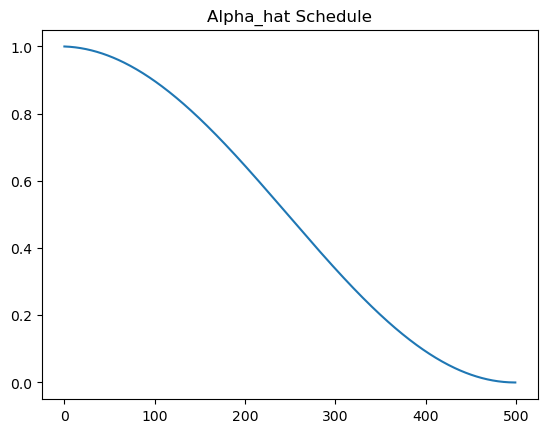

In [65]:
import matplotlib.pyplot as plt
plt.plot(trainer.noise_sched.alpha_hat.cpu().numpy())
plt.title("Alpha_hat Schedule"); plt.show()


In [53]:
for i in range(5000):
    trainer.lr_sched.step()
    print(trainer.opt.param_groups[0]['lr'])


2.1280000000000006e-05
2.1320000000000006e-05
2.1360000000000006e-05
2.1400000000000002e-05
2.144e-05
2.148e-05
2.152e-05
2.156e-05
2.16e-05
2.164e-05
2.168e-05
2.1720000000000002e-05
2.1760000000000005e-05
2.1800000000000008e-05
2.1840000000000008e-05
2.1880000000000007e-05
2.1920000000000007e-05
2.196000000000001e-05
2.200000000000001e-05
2.2040000000000006e-05
2.2080000000000002e-05
2.2119999999999998e-05
2.2159999999999998e-05
2.2199999999999998e-05
2.2239999999999997e-05
2.2279999999999997e-05
2.2319999999999996e-05
2.236e-05
2.2399999999999996e-05
2.2439999999999995e-05
2.2479999999999995e-05
2.2519999999999994e-05
2.2559999999999994e-05
2.2599999999999994e-05
2.2639999999999993e-05
2.2679999999999993e-05
2.2719999999999993e-05
2.2759999999999992e-05
2.2799999999999995e-05
2.2839999999999995e-05
2.2879999999999998e-05
2.2919999999999997e-05
2.2959999999999997e-05
2.3e-05
2.3040000000000003e-05
2.3080000000000003e-05
2.3120000000000002e-05
2.3160000000000002e-05
2.3200000000000005

C:\Users\User\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [66]:
# Прямо после применения MelNormalize
global_mean, global_std = 0, 0
total = 0
for mel, _ in train_dl:
    mel = mel_norm(mel)
    global_mean += mel.sum().item()
    global_std  += (mel ** 2).sum().item()
    total += mel.numel()
mean = global_mean / total
std = (global_std / total - mean**2) ** 0.5
print('Global norm mean:', mean)
print('Global norm std:', std)


Global norm mean: -2.5268872578938802e-08
Global norm std: 1.0000000498860662


In [56]:
print("mel_mean:", mel_mean)
print("mel_std:", mel_std)


mel_mean: -5.83600191796875
mel_std: 5.234365961576919


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# --- Dummy ResBlock ---
class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(1, channels, affine=True)
        self.act   = nn.SiLU()
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(1, channels, affine=True)

        # Init: только второй norm.bias в 0 (по желанию)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)
        nn.init.ones_(self.norm1.weight)
        nn.init.zeros_(self.norm1.bias)
        nn.init.ones_(self.norm2.weight)
        nn.init.zeros_(self.norm2.bias)

    def forward(self, x):
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act(h)
        h = self.conv2(h)
        h = self.norm2(h)
        return x + h


# --- Быстрый тест обучаемости ---
def test_overfit_resblock(device='cuda'):
    B, C, H, W = 4, 32, 16, 16
    x = torch.randn(B, C, H, W, device=device)
    target = torch.randn(B, C, H, W, device=device)

    model = ResBlock(C).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-2)

    for step in range(500):
        pred = model(x)
        loss = F.mse_loss(pred, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if step % 50 == 0 or step == 499:
            print(f"step {step:3d}  loss: {loss.item():.6f}")

    # Итог: если loss → 0, всё работает (оптимайзер, resblock, нормализации)
    print("FINAL LOSS:", loss.item())
    return loss.item()

if __name__ == "__main__":
    test_overfit_resblock('cuda' if torch.cuda.is_available() else 'cpu')


step   0  loss: 3.010881
step  50  loss: 0.609057
step 100  loss: 0.385976
step 150  loss: 0.308732
step 200  loss: 0.269394
step 250  loss: 0.248827
step 300  loss: 0.235479
step 350  loss: 0.229466
step 400  loss: 0.222483
step 450  loss: 0.217966
step 499  loss: 0.214843
FINAL LOSS: 0.2148425430059433


In [76]:
# # ──────────────────────────  VAE UNIT-NORMAL PATCH  ──────────────────────────
# import itertools, torch, numpy as np, torch.nn.functional as F

# # 1. ─── собираем статистики латента (≈50k примеров) ──────────────────────────
# BATCHES = 400                                           # 400×128 ≈ 5·10⁴
# m_list, s_list = [], []

# with torch.no_grad():
#     for mel, _ in itertools.islice(train_dataloader, BATCHES):
#         mel = mel.to(device).float()                    # (B,1,80,80)
#         z, _, _ = vae.sample(mel)                       # (B,32,h,w) – «сырой» латент
#         m_list.append( z.mean([0,2,3]) )                # (32,)
#         s_list.append( z.var ([0,2,3]).sqrt() )         # (32,)

# mu_prior  = torch.stack(m_list).mean(0).view(1,-1,1,1).to(device)
# std_prior = torch.stack(s_list).mean(0).view(1,-1,1,1).to(device)

# print("─ latenta stats collected:",
#       f"\n  mean  (min/max): {mu_prior.min():+.3f} … {mu_prior.max():+.3f}",
#       f"\n  std   (min/max): {std_prior.min():.3f} … {std_prior.max():.3f}")

# # 2. ─── вспомогательные функции нормировки ───────────────────────────────────
# @torch.no_grad()
# def _to_unit(z):   return (z - mu_prior) / std_prior.clamp_min(1e-3)

# @torch.no_grad()
# def _from_unit(z): return z * std_prior + mu_prior

# # 3. ─── monkey-patch VAE (никаких новых классов) ─────────────────────────────
# _old_decode  = vae.decode
# _old_sample  = vae.sample
# _old_forward = vae.forward

# def _decode_patched(z):                 # z уже в unit-Normal
#     return _old_decode(_from_unit(z))   # декодеру вернём «сырой» масштаб

# def _sample_patched(x):                 # → (z_unit, mu_unit, logvar)
#     z, mu, logvar = _old_sample(x)      # всё ещё «сырой»
#     return _to_unit(z), _to_unit(mu), logvar

# def _forward_patched(x):                # на случай прямого вызова vae(x)
#     recon, z, mu, logvar = _old_forward(x)
#     return recon, _to_unit(z), _to_unit(mu), logvar

# vae.decode  = _decode_patched
# vae.sample  = _sample_patched
# vae.forward = _forward_patched

# print("✓ VAE patched — все выходы теперь unit-Normal")

# # 4. ─── быстрая sanity-проверка ───────────────────────────────────────────────
with torch.no_grad():
    mel,_ = next(iter(train_dataloader))
    mel   = mel.to(device).float()

    mu, logvar = vae.encode(mel[:256])   # <- именно encode
    z          = mu                      # или mu + ε·σ

print("latent μ mean:", mu.mean().item(),
      "latent μ std:",  mu.std ().item())

# при корректной нормировке → mean ≈ 0, std ≈ 1
# ──────────────────────────────────────────────────────────────────────────────


latent μ mean: 0.02391430363059044 latent μ std: 0.608071506023407


In [15]:
Path("samples").mkdir(exist_ok=True) 

In [16]:
# # достаём настоящий AudioDataset
# raw_ds = (train_dataloader.dataset.dataset
#           if isinstance(train_dataloader.dataset, torch.utils.data.Subset)
#           else train_dataloader.dataset)
# count = 0
# for i in range(len(raw_ds)):
#     mel, txt = raw_ds[i]
#     if mel is None or not torch.is_tensor(mel):
#         count += 1
# count


In [20]:
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.utils.fetching import LocalStrategy

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

vocoder = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-libritts-16kHz",
    run_opts={"device": DEVICE},
    savedir="pretrained_models/hifigan_16k_80",
    local_strategy=LocalStrategy.COPY
).to(DEVICE).eval()

# Если вы хотите ускорить инференс — удаляем weight norm из внутреннего модуля:
if hasattr(vocoder, "hifigan") and hasattr(vocoder.hifigan, "remove_weight_norm"):
    vocoder.hifigan.remove_weight_norm()
elif hasattr(vocoder, "remove_weight_norm"):
    vocoder.remove_weight_norm()  # на всякий случай


C:\Users\User\anaconda3\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [22]:
import os, re, torch, torchaudio
from pathlib import Path

# ────────────── utils ──────────────
SR, N_FFT, HOP, WIN, N_MELS = 16_000, 1024, 256, 1024, 80
@torch.no_grad()
def vocode(mel_log: torch.Tensor) -> torch.Tensor:
    """
    mel_log — (B, 80, T)  в natural-log(power) при SR = 16 000.
    Возвращает (B, T) в диапазоне ±1  на CPU.
    """
    if mel_log.dim() == 4:           # (B,1,80,T) → (B,80,T)
        mel_log = mel_log.squeeze(1)

    wav = vocoder(mel_log.to(DEVICE))   # (B, 1, T)
    wav = wav.squeeze(1)                         # (B, T)
    wav = wav / wav.abs().amax(dim=1, keepdim=True).clamp_min(1e-6)
    return wav.cpu()

@torch.no_grad()
def text_to_speech(text: str,
                   tts,        # diffusion-UNet
                   vae,        # ваш VAE
                   sched,      # noise scheduler
                   temp: float = 0.5,
                   device=None):

    device = device or next(tts.parameters()).device
    ids = tts.word_enc.tokenize([text]).to(device)

    # ── размер латента ──
    dummy = torch.zeros(1, 1, 80, 80, device=device)
    zshape = vae.encode(dummy)[0].shape          # (1, C, H, W)

    # ── обратный процесс ──
    z = torch.randn(zshape, device=device) * temp
    for t in reversed(range(sched.steps)):
        eps = tts(z, ids, torch.tensor([t], device=device))
        if eps.shape[-2:] != z.shape[-2:]:
            eps = F.interpolate(eps, z.shape[-2:], mode="bilinear")
        z = sched.restore_image(z, eps, t, sigma=0.0 if t < sched.steps*0.2 else 1e-4)

    # ── VAE → mel → HiFi-GAN ──
    mel_log = vae.decode(z).squeeze(0)           # (1,1,80,T) → (1,80,T)
    wav = vocode(mel_log)                        # (1,T)  cpu

    return wav[0]      

def slugify(text, length=16):
    txt = re.sub(r"\s+", "_", text.lower())
    return re.sub(r"[^\w\d_]+", "", txt)[:length]

# ────────────── инициализация моделей ──────────────
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tts_model = TTS_diffusion(
    input_channels=32,
    hidden_dims=128,
    alphabet="абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ",
    emb_size_word=64,
    emb_size_noise=32,
    noise_steps=300,
    max_word_size=256,
    max_time_size=2048
).to(DEVICE)

trainer = TTS_Trainer(
    model    = tts_model,
    vae      = vae,                 # ← ваша заранее загруженная VAE
    train_dl = train_dataloader,
    val_dl   = val_dataloader,
    noise_steps=300,
    epochs   = 30
)

Path("./samples").mkdir(exist_ok=True)

for epoch in range(trainer.epochs):
    print(f"\nEpoch {epoch+1}/{trainer.epochs}")

    # 1) обучение (VAE уже .eval() внутри train_loop)
    trainer.train_loop(epoch=epoch)

    # 2) быстрая валидация
    val_mse, val_l2 = trainer.val_loop()
    print(f"ε-L2 val = {val_l2:.4f}   MSE = {val_mse:.6f}")

    # 3) визуальная диффузия
    trainer.draw_diffusion(f"diff_ep{epoch+1:02d}.png")

    # 4) аудио-пробы
    trainer.ema.eval()            # берем EMA-версию для inference
    for phrase in ["привет", "Владимир"]:
        wav = text_to_speech(
            phrase,
            trainer.ema.module,   # ← EMA-копия модели
            trainer.vae,
            trainer.noise_sched,
            temp=0.7,
            device=DEVICE
        )
        fn = f"./samples/ep{epoch+1:04d}_{slugify(phrase)}.mp3"
        torchaudio.save(fn, wav.unsqueeze(0), SR)
        print("✓", fn)

    # 5) ЧЕКПОИНТЫ — только TTS-модель
    torch.save(trainer.model.state_dict(),
               f"TTS_Diffusion_8.{epoch+1:02d}.pt")


β[:10] = [0.0001564  0.00021058 0.00026447 0.00031835 0.00037247 0.00042647
 0.00048053 0.00053447 0.00058872 0.00064272]

Epoch 1/30


Train 00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

[val] ε-L2 = 0.0943   MSE = 0.013544
ε-L2 val = 0.0943   MSE = 0.013544
✓ ./samples/ep0001_привет.mp3
✓ ./samples/ep0001_владимир.mp3

Epoch 2/30


Train 01:   3%|███████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

KeyboardInterrupt: 

In [95]:
# Генерация после обучения (пример)
trainer.ema.eval()
text = "привет"
wav = text_to_speech(
    text,
    trainer.ema.module,
    trainer.vae,
    trainer.noise_sched,
    temp=0.7,
    device=DEVICE
)ф
# Нормализация ±1
wav = wav / wav.abs().max().clamp_min(1e-6)
torchaudio.save(f"sample_{slugify(text)}.wav", wav.unsqueeze(0), SR)
print(f"Saved sample_{slugify(text)}.wav")


Saved sample_привет.wav


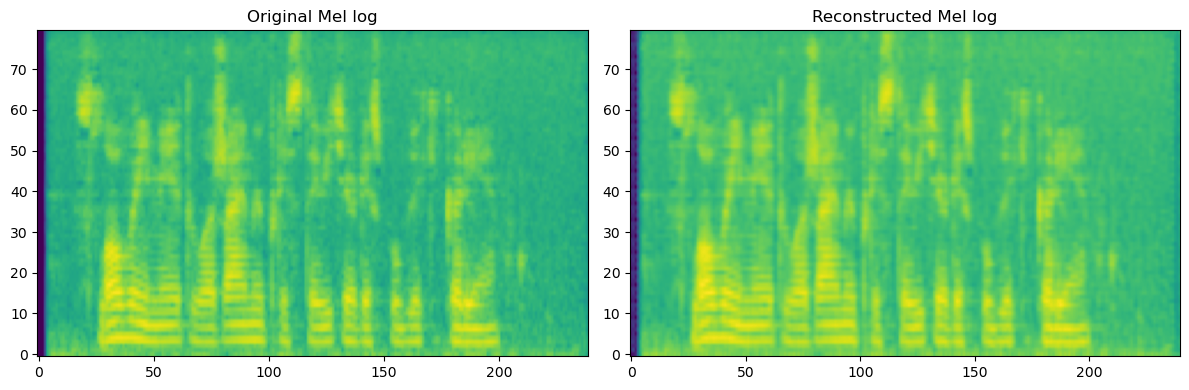

Saved vae_recon.wav


In [107]:
@torch.no_grad()
def test_vae_single(wav_path):
    wav, sr = torchaudio.load(wav_path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)

    wav = wav.to(DEVICE)

    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=SR, n_fft=1024, hop_length=256,
        win_length=1024, n_mels=80, f_min=0, f_max=8000,
        power=1.0
    ).to(DEVICE)

    mel = mel_spec(wav)  # (channels=1, n_mels=80, time)
    mel_log = torch.log(mel + 1e-6).unsqueeze(0).to(DEVICE)  # (1, 1, 80, T)

    mu, _ = vae.encode(mel_log)            # (1, C, H, W)
    mel_rec = vae.decode(mu)                # (1, 1, 80, T)

    mel_rec = mel_rec.squeeze(0).squeeze(0).cpu()  # (80, T)
    mel_log = mel_log.squeeze(0).squeeze(0).cpu()  # (80, T)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.title("Original Mel log")
    plt.imshow(mel_log.numpy(), aspect='auto', origin='lower')
    plt.subplot(1,2,2)
    plt.title("Reconstructed Mel log")
    plt.imshow(mel_rec.numpy(), aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()

    wav_out = vocoder(mel_rec.unsqueeze(0).to(DEVICE))  # (1, 1, T)
    wav_out = wav_out.squeeze(0).cpu()                  # (1, T) или (T,)
    if wav_out.dim() == 1:
        wav_out = wav_out.unsqueeze(0)                   # (1, T)
    wav_out = wav_out / wav_out.abs().max().clamp_min(1e-6)

    torchaudio.save("vae_recon.wav", wav_out, SR)
    print("Saved vae_recon.wav")

# Запуск
test_vae_single("E:/data/bare_data/common_voice_ru_18849004.wav")


In [104]:
@torch.no_grad()
def test_vae_audio(wav_path):
    wav, sr = torchaudio.load(wav_path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.to(DEVICE)

    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=SR, n_fft=1024, hop_length=256,
        win_length=1024, n_mels=80, f_min=0, f_max=8000,
        power=1.0
    ).to(DEVICE)

    mel = mel_spec(wav)                 # (1, 80, T)
    mel = mel.unsqueeze(0)              # (1, 1, 80, T) — batch + channel
    mel_log = torch.log(mel + 1e-6)    # (1, 1, 80, T)

    mu, _ = vae.encode(mel_log)
    mel_rec = vae.decode(mu).squeeze(0).squeeze(0)  # (80, T)

    # Вокодируем восстановленный mel обратно в аудио
    wav_rec = vocode(mel_rec.unsqueeze(0))  # (1, T)
    torchaudio.save("vae_recon.wav", wav_rec, SR)
    print("Saved vae_recon.wav — послушай результат")

# Запуск
test_vae_audio("E:/data/bare_data/common_voice_ru_18849004.wav")


Saved vae_recon.wav — послушай результат


In [106]:
import torch, torchaudio

SR = 16000

# 1. Load WAV (человеческая речь)
wav, sr = torchaudio.load("E:/data/bare_data/common_voice_ru_18849004.wav")
if sr != SR:
    wav = torchaudio.functional.resample(wav, sr, SR)

# 2. MEL как у vocoder
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    f_min=0,
    f_max=8000,
    power=1.0,
)(wav)
mel_log = torch.log(mel + 1e-6)

# 3. VOCODER
mel_log = mel_log.to(DEVICE).float()
with torch.no_grad():
    wav_out = vocoder(mel_log)
    while wav_out.dim() > 2:
        wav_out = wav_out.squeeze(1)
    wav_out = wav_out.cpu()
    wav_out = wav_out / (wav_out.abs().max().clamp_min(1e-6))
torchaudio.save("test_direct_vocoder.wav", wav_out, SR)
print("✓ test_direct_vocoder.wav готов")


✓ test_direct_vocoder.wav готов


In [94]:
# 1. Прямо с WAV
wav, sr = torchaudio.load("E:/data/bare_data/common_voice_ru_18849005.wav")
if sr != SR:
    wav = torchaudio.functional.resample(wav, sr, SR)
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    f_min=0,
    f_max=8000,
    power=1.0,
)(wav)
mel_log = torch.log(mel + 1e-6)
mel_log = mel_log.to(DEVICE).float()
with torch.no_grad():
    wav_out = vocoder(mel_log)
    while wav_out.dim() > 2:
        wav_out = wav_out.squeeze(1)
    wav_out = wav_out.cpu()
    wav_out = wav_out / (wav_out.abs().max().clamp_min(1e-6))
torchaudio.save("test_vocoder_direct.wav", wav_out, SR)
print("✓ test_vocoder_direct.wav готов")


✓ test_vocoder_direct.wav готов


In [19]:
mel_real, _ = next(iter(train_dataloader))  # (B, 80, T)
mel_real = mel_real[0].unsqueeze(0)        # (1, 80, T)
mel_real = mel_real.to(DEVICE).float()     # (1, 80, T)
if mel_real.dim() == 3:
    mel_real = mel_real.unsqueeze(1)       # (1, 1, 80, T)

with torch.no_grad():
    mu, _ = vae.encode(mel_real)           # (1, C, H, W)
    mel_rec = vae.decode(mu)               # (1, 1, 80, T)
    mel_rec = mel_rec.squeeze(0).squeeze(0).cpu() # (80, T)

print("mel_real.shape:", mel_real.shape)
print("mel_rec.shape:", mel_rec.shape)
print("mel_real stats:", mel_real.min().item(), mel_real.max().item(), mel_real.mean().item(), mel_real.std().item())
print("mel_rec  stats:", mel_rec.min().item(),  mel_rec.max().item(),  mel_rec.mean().item(),  mel_rec.std().item())


mel_real.shape: torch.Size([1, 1, 80, 120])
mel_rec.shape: torch.Size([80, 120])
mel_real stats: -1.5224953889846802 2.4987752437591553 -0.42256301641464233 1.044217824935913
mel_rec  stats: -4.814520359039307 2.9944000244140625 -0.5308788418769836 1.2623062133789062


In [81]:
from speechbrain.pretrained import EncoderDecoderASR

# Здесь укажи свою модель, возможно есть доступ к preprocessor
model = EncoderDecoderASR.from_hparams(source="speechbrain/tts-hifigan-libritts-16kHz")
mel_func = model.audio_pipeline # или model.hparams.audio_pipeline


ValueError: Need hparams['tokenizer']

In [83]:
with open("pretrained_models/hifigan_16k_80/hyperparams.yaml", "r", encoding="utf-8") as f:
    lines = f.readlines()

print("--- MEL-параметры ---")
for line in lines:
    if "mel" in line.lower() or "spect" in line.lower() or "fft" in line.lower():
        print(line.strip())


--- MEL-параметры ---


mel_log.shape: torch.Size([1, 80, 196]), min: -10.062267303466797, max: 4.104110240936279
wav_voc.shape: torch.Size([1, 52736])
✓ test_vocoder_check.wav сохранён. Открой и проверь!


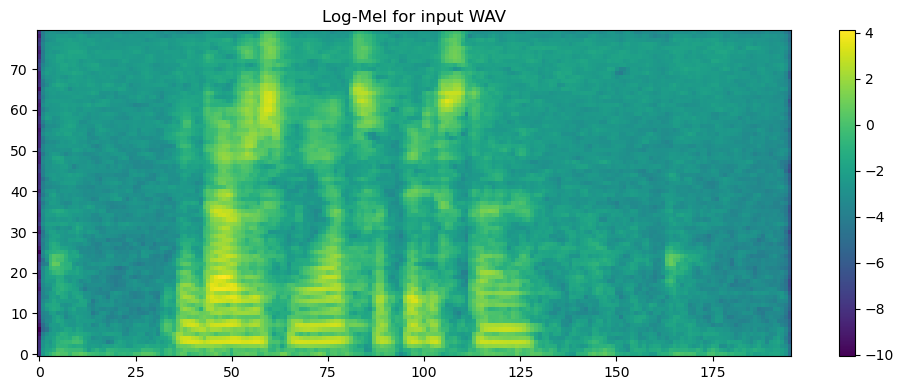

In [91]:
import torch
import torchaudio
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.utils.fetching import LocalStrategy
import os

SR = 16000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Загрузи vocoder из SpeechBrain (LibriTTS 16kHz)
vocoder = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-libritts-16kHz",
    run_opts={"device": DEVICE},
    savedir="pretrained_models/hifigan_16k_80",
    local_strategy=LocalStrategy.COPY
).to(DEVICE).eval()
if hasattr(vocoder, "hifigan") and hasattr(vocoder.hifigan, "remove_weight_norm"):
    vocoder.hifigan.remove_weight_norm()

# 2. ЗАГРУЗИ WAV-файл (должен быть 16kHz mono, LibriTTS или свой)
wav_path = "E:/data/bare_data/common_voice_ru_18849007.wav"  # свой путь
wav, sr = torchaudio.load(wav_path)
if sr != SR:
    wav = torchaudio.functional.resample(wav, sr, SR)
wav = wav.mean(dim=0, keepdim=True)  # mono

# 3. MEL как у speechbrain/libritts-hifigan
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    f_min=0,
    f_max=8000,
    power=1.0
)(wav)  # (1, 80, T)
mel_log = torch.log(mel + 1e-6)     # (1, 80, T)

print(f"mel_log.shape: {mel_log.shape}, min: {mel_log.min().item()}, max: {mel_log.max().item()}")

mel_log = mel_log.to(DEVICE).float()

# 4. Прогон через vocoder
with torch.no_grad():
    wav_voc = vocoder(mel_log)
    while wav_voc.dim() > 2:
        wav_voc = wav_voc.squeeze(1)
    wav_voc = wav_voc.cpu()
    wav_voc = wav_voc / (wav_voc.abs().max().clamp_min(1e-6))

print("wav_voc.shape:", wav_voc.shape)
torchaudio.save("test_vocoder_check.wav", wav_voc, SR)
print("✓ test_vocoder_check.wav сохранён. Открой и проверь!")

# 6. Быстрый визуальный контроль спектра
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.imshow(mel_log[0].cpu(), aspect="auto", origin="lower")
plt.title("Log-Mel for input WAV")
plt.colorbar()
plt.tight_layout()
plt.show()


TypeError: Invalid shape (250,) for image data

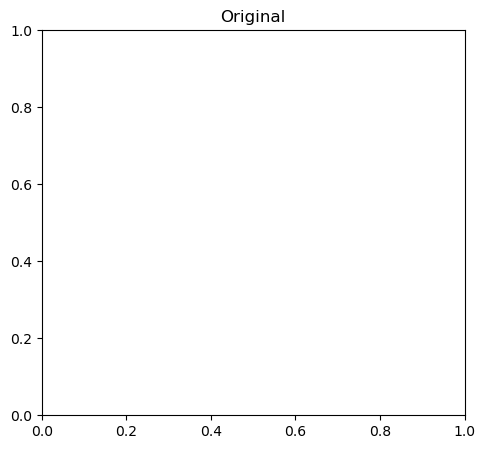

In [92]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(mel_real[0,0].cpu(), aspect='auto', origin='lower')
plt.subplot(1,2,2)
plt.title('Reconstructed')
plt.imshow(mel_rec.cpu(), aspect='auto', origin='lower')
plt.show()
wav = vocode(mel_rec.unsqueeze(0))
import IPython.display as ipd
ipd.display(ipd.Audio(wav.cpu().numpy(), rate=SR))


In [84]:
print("mel_real min/max:", mel_real.min().item(), mel_real.max().item())
print("mel_rec min/max:", mel_rec.min().item(), mel_rec.max().item())
print("exp(mel_rec) min/max:", mel_rec.exp().min().item(), mel_rec.exp().max().item())
"E:/data/bare_data/common_voice_ru_18849003.wav"


mel_real min/max: -13.815510749816895 7.03397798538208
mel_rec min/max: -17.81907844543457 9.015344619750977
exp(mel_rec) min/max: 1.8250407407549574e-08 8228.3818359375


'E:/data/bare_data/common_voice_ru_18849003.wav'

In [33]:
import torch
import torchaudio
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.utils.fetching import LocalStrategy

# --- 1. Настройки ---
SR = 22050  # sample rate
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 2. Загрузка/инициализация vocoder ---
vocoder = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-libritts-16kHz",
    run_opts={"device": DEVICE},
    savedir="pretrained_models/hifigan_16k_80",
    local_strategy=LocalStrategy.COPY
).to(DEVICE).eval()

# (ускорение инференса — по желанию)
if hasattr(vocoder, "hifigan") and hasattr(vocoder.hifigan, "remove_weight_norm"):
    vocoder.hifigan.remove_weight_norm()

# --- 3. Пример: загрузи wav, получи mel, переведи в логарифм ---
wav, sr = torchaudio.load("E:/data/bare_data/common_voice_ru_18849004.wav")
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR, n_fft=800, hop_length=200, n_mels=128
)(wav)  # (channels, 80, T)
mel_log = torch.log(mel + 1e-6)  # (channels, 80, T)

# --- 4. Привести к нужному виду (B, 80, T) ---
if mel_log.dim() == 3 and mel_log.shape[0] == 1:
    mel_log = mel_log   # (1, 80, T)
elif mel_log.dim() == 3 and mel_log.shape[0] != 1:
    mel_log = mel_log[:1]  # возьмём только первый канал
elif mel_log.dim() == 2:
    mel_log = mel_log.unsqueeze(0)
else:
    raise ValueError(f"Неверная форма mel_log: {mel_log.shape}")

mel_log = mel_log.to(DEVICE).float()

# --- 5. Прогон через vocoder ---
with torch.no_grad():
    wav_voc = vocoder(mel_log)     # (B, T)
    wav_voc = wav_voc.squeeze(0).cpu()  # (T,)

# --- 6. Сохраняем результат ---
if wav_voc.dim() == 1:
    wav_voc = wav_voc.unsqueeze(0)    # (1, T)

wav_voc = wav_voc / (wav_voc.abs().max().clamp_min(1e-6))
torchaudio.save("test_vocoder_out.wav", wav_voc, SR)
print("✓ test_vocoder_out.wav сохранён и готов к прослушиванию!")

print("mel_log stats: min", mel_log.min().item(), "max", mel_log.max().item())
print("wav_voc stats: min", wav_voc.min().item(), "max", wav_voc.max().item())


RuntimeError: Given groups=1, weight of size [512, 80, 7], expected input[1, 128, 322] to have 80 channels, but got 128 channels instead

In [48]:
import torch
import torchaudio

# --- 1. Возьми реальный mel из train ---
mel_real, _ = next(iter(train_dataloader))      # (B, 80, T)
mel_real = mel_real[0:1].to(DEVICE).float()     # (1, 80, T)

with torch.no_grad():
    # --- 2. VAE encode-decode ---
    mu, _ = vae.encode(mel_real)                # (1, C, H, W)
    mel_rec = vae.decode(mu)                    # (1, 1, 80, T) или (1, 80, T)
    if mel_rec.dim() == 4:
        mel_rec = mel_rec.squeeze(1)            # (1, 80, T)
    mel_rec = mel_rec.to(DEVICE)

    # --- 3. vocoder ---
    wav = vocoder(mel_rec)                      # (1, T) или (1, 1, T)
    if wav.dim() == 3:
        wav = wav.squeeze(0).squeeze(0)         # (T,)
    elif wav.dim() == 2:
        wav = wav.squeeze(0)                    # (T,)
    wav = wav / (wav.abs().max().clamp_min(1e-6))

    wav_to_save = wav.unsqueeze(0).cpu()        # (1, T), обязательно .cpu()!
    torchaudio.save("test_vae_ae.wav", wav_to_save, SR)
    print("✓ test_vae_ae.wav готов")


✓ test_vae_ae.wav готов


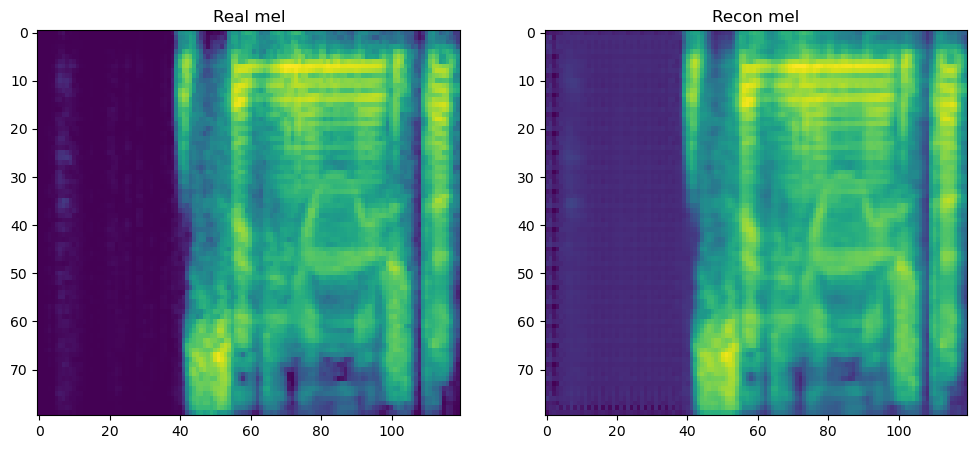

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.imshow(mel_real.squeeze().cpu(), aspect='auto')
plt.title('Real mel')
plt.subplot(1,2,2)
plt.imshow(mel_rec.squeeze().cpu(), aspect='auto')
plt.title('Recon mel')
plt.show()


In [50]:
print("mel_real: min", mel_real.min().item(), "max", mel_real.max().item(), "mean", mel_real.mean().item(), "std", mel_real.std().item())
print("mel_rec:  min", mel_rec.min().item(),  "max", mel_rec.max().item(),  "mean", mel_rec.mean().item(),  "std", mel_rec.std().item())


mel_real: min -13.815510749816895 max 8.001481056213379 mean -5.573571681976318 std 6.547760486602783
mel_rec:  min -17.71457862854004 max 8.761937141418457 mean -6.013898849487305 std 7.088321685791016


In [51]:
import torch
import torchaudio
import numpy as np

# -- Твой VAE и vocoder уже должны быть загружены и в режиме .eval()
# Предполагаем: DEVICE, vae, vocoder, train_dataloader уже объявлены

SR = 16000

# 1. Взять реальный mel
mel_real, _ = next(iter(train_dataloader))   # (B, 80, T)
mel_real = mel_real[0:1].to(DEVICE).float()  # (1, 80, T)

with torch.no_grad():
    mu, _ = vae.encode(mel_real)         # (1, C, H, W)
    mel_rec = vae.decode(mu)             # (1, 1, 80, T) ИЛИ (1, 80, T)
    if mel_rec.dim() == 4:
        mel_rec = mel_rec.squeeze(1)     # (1, 80, T)

    # Clamp (чтобы убрать выбросы)
    mel_rec_clamped = mel_rec.clamp(min=-4.0, max=3.0)

    # SNR/MSE
    mse = ((mel_real - mel_rec_clamped)**2).mean().item()
    snr = 10 * np.log10((mel_real.cpu().numpy()**2).mean() / (mse + 1e-8))
    print(f"Clamp: MSE={mse:.4f}  SNR={snr:.2f} dB")
    print("mel_real shape:", mel_real.shape, "mel_rec_clamped shape:", mel_rec_clamped.shape)

    # -- Подаём в vocoder --
    # ВАЖНО: vocoder ждет (B, 80, T)
    wav = vocoder(mel_rec_clamped)  # (1, T) или (B, T)
    wav = wav.squeeze().cpu()
    wav = wav / (wav.abs().max().clamp_min(1e-6))

    # torchaudio.save ждёт (channels, time) => делаем (1, T)
    if wav.dim() == 1:
        wav = wav.unsqueeze(0)
    torchaudio.save("test_vae_ae_clamped.wav", wav, SR)
    print("✓ test_vae_ae_clamped.wav готов")


Clamp: MSE=31.3692  SNR=3.82 dB
mel_real shape: torch.Size([1, 1, 80, 120]) mel_rec_clamped shape: torch.Size([1, 80, 120])
✓ test_vae_ae_clamped.wav готов


In [57]:
import torch
import torchaudio
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.utils.fetching import LocalStrategy

SR = 16000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 1. Инициализация vocoder ---
vocoder = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-libritts-16kHz",
    run_opts={"device": DEVICE},
    savedir="pretrained_models/hifigan_16k_80",
    local_strategy=LocalStrategy.COPY
).to(DEVICE).eval()

if hasattr(vocoder, "hifigan") and hasattr(vocoder.hifigan, "remove_weight_norm"):
    vocoder.hifigan.remove_weight_norm()

# --- 2. Загрузи real wav и сделай MEL ---
wav, sr = torchaudio.load("E:/data/bare_data/common_voice_ru_18849007.wav")
mel_real = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR, n_fft=800, hop_length=200, n_mels=80
)(wav)  # (channels, 80, T)
mel_real = torch.log(mel_real + 1e-6)  # (channels, 80, T)

# --- 3. Убери channel dim: (1, 80, T) ---
if mel_real.dim() == 3 and mel_real.shape[0] == 1:
    mel_real = mel_real[0]    # (80, T)
if mel_real.dim() == 2:
    mel_real = mel_real.unsqueeze(0)   # (1, 80, T)
mel_real = mel_real.to(DEVICE).float()

print("mel_real.shape:", mel_real.shape)  # ДОЛЖНО быть (1, 80, T)

# --- 4. Прогон через vocoder ---
with torch.no_grad():
    wav_real = vocoder(mel_real)  # (B, T) или (B, 1, T)
    while wav_real.dim() > 2:
        wav_real = wav_real.squeeze(1)
    wav_real = wav_real.cpu()
    wav_real = wav_real / (wav_real.abs().max().clamp_min(1e-6))

print("wav_real.shape:", wav_real.shape)  # (1, T)
torchaudio.save("test_vocoder_on_real.wav", wav_real, SR)
print("✓ test_vocoder_on_real.wav готов")


mel_real.shape: torch.Size([1, 80, 250])
wav_real.shape: torch.Size([1, 66560])
✓ test_vocoder_on_real.wav готов


In [58]:
import torch
import torchaudio

SR = 16000

# --- 1. Загрузка WAV ---
wav, sr = torchaudio.load("E:/data/bare_data/common_voice_ru_18849007.wav")
if sr != SR:
    wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=SR)

# --- 2. Делай MEL СПЕКТРОГРАММУ строго как у vocoder ---
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    f_min=0,
    f_max=8000,
    power=1.0,
)(wav)
mel_log = torch.log(mel + 1e-6)  # именно log

print("mel_log.shape:", mel_log.shape)  # (channels, 80, T)


mel_log.shape: torch.Size([1, 80, 196])


In [59]:
import torch
import torchaudio
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.utils.fetching import LocalStrategy

SR = 16000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 1. Init vocoder ---
vocoder = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-libritts-16kHz",
    run_opts={"device": DEVICE},
    savedir="pretrained_models/hifigan_16k_80",
    local_strategy=LocalStrategy.COPY
).to(DEVICE).eval()
if hasattr(vocoder, "hifigan") and hasattr(vocoder.hifigan, "remove_weight_norm"):
    vocoder.hifigan.remove_weight_norm()

# --- 2. Загрузи WAV и сделай MEL ---
wav, sr = torchaudio.load("E:/data/bare_data/common_voice_ru_18849007.wav")
if sr != SR:
    wav = torchaudio.functional.resample(wav, sr, SR)

mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    f_min=0,
    f_max=8000,
    power=1.0,
)(wav)
mel_log = torch.log(mel + 1e-6)

# --- 3. Подготовить к форме (1, 80, T) ---
if mel_log.dim() == 3 and mel_log.shape[0] == 1:
    mel_log = mel_log[0]
if mel_log.dim() == 2:
    mel_log = mel_log.unsqueeze(0)
mel_log = mel_log.to(DEVICE).float()

print("mel_log.shape:", mel_log.shape)

# --- 4. Вокодирование ---
with torch.no_grad():
    wav_real = vocoder(mel_log)
    while wav_real.dim() > 2:
        wav_real = wav_real.squeeze(1)
    wav_real = wav_real.cpu()
    wav_real = wav_real / (wav_real.abs().max().clamp_min(1e-6))

print("wav_real.shape:", wav_real.shape)
torchaudio.save("test_vocoder_on_real.wav", wav_real, SR)
print("✓ test_vocoder_on_real.wav готов")


mel_log.shape: torch.Size([1, 80, 196])
wav_real.shape: torch.Size([1, 52736])
✓ test_vocoder_on_real.wav готов


In [61]:
from speechbrain.dataio.dataio import read_audio

example_wav = "pretrained_models/hifigan_16k_80/example.wav"  # speechbrain обычно кладёт примеры в свою папку
if os.path.exists(example_wav):
    wav, sr = torchaudio.load(example_wav)
    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=SR, n_fft=1024, hop_length=256,
        win_length=1024, n_mels=80, f_min=0, f_max=8000, power=1.0
    )(wav)
    mel_log = torch.log(mel + 1e-6)
    mel_log = mel_log.to(DEVICE).float()
    with torch.no_grad():
        wav_out = vocoder(mel_log)
        while wav_out.dim() > 2:
            wav_out = wav_out.squeeze(1)
        wav_out = wav_out.cpu()
        wav_out = wav_out / (wav_out.abs().max().clamp_min(1e-6))
    torchaudio.save("test_vocoder_on_example.wav", wav_out, SR)


In [64]:
import os

print(os.listdir("pretrained_models/hifigan_16k_80"))


['generator.ckpt', 'hyperparams.yaml']


In [63]:
import torch
import torchaudio
from speechbrain.inference.vocoders import HIFIGAN
from speechbrain.utils.fetching import LocalStrategy

SR = 16000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- 1. Инициализация vocoder ---
vocoder = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-libritts-16kHz",
    run_opts={"device": DEVICE},
    savedir="pretrained_models/hifigan_16k_80",
    local_strategy=LocalStrategy.COPY
).to(DEVICE).eval()
if hasattr(vocoder, "hifigan") and hasattr(vocoder.hifigan, "remove_weight_norm"):
    vocoder.hifigan.remove_weight_norm()

# --- 2. ЗАГРУЗИ свой WAV здесь ---
wav_path = "E:/data/bare_data/common_voice_ru_18849007.wav"  # ← путь к твоему файлу
wav, sr = torchaudio.load(wav_path)
if sr != SR:
    wav = torchaudio.functional.resample(wav, sr, SR)

# --- 3. Сделай mel-спектрограмму ТЕМ ЖЕ способом, как у vocoder ---
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    n_mels=80,
    f_min=0,
    f_max=8000,
    power=1.0,
)(wav)
mel_log = torch.log(mel + 1e-6)

# --- 4. Подготовь (1, 80, T) ---
if mel_log.dim() == 3 and mel_log.shape[0] == 1:
    mel_log = mel_log[0]
if mel_log.dim() == 2:
    mel_log = mel_log.unsqueeze(0)
mel_log = mel_log.to(DEVICE).float()

# --- 5. Вокодирование ---
with torch.no_grad():
    wav_out = vocoder(mel_log)
    while wav_out.dim() > 2:
        wav_out = wav_out.squeeze(1)
    wav_out = wav_out.cpu()
    wav_out = wav_out / (wav_out.abs().max().clamp_min(1e-6))

torchaudio.save("test_vocoder_on_wav.wav", wav_out, SR)
print("✓ test_vocoder_on_wav.wav сохранён")

print("mel_log stats: min", mel_log.min().item(), "max", mel_log.max().item())
print("wav_out stats: min", wav_out.min().item(), "max", wav_out.max().item())


✓ test_vocoder_on_wav.wav сохранён
mel_log stats: min -10.062267303466797 max 4.104110240936279
wav_out stats: min -1.0 max 0.9994811415672302


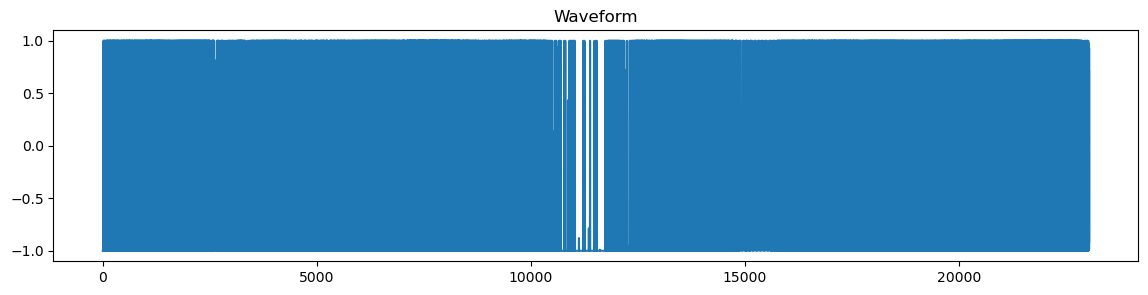

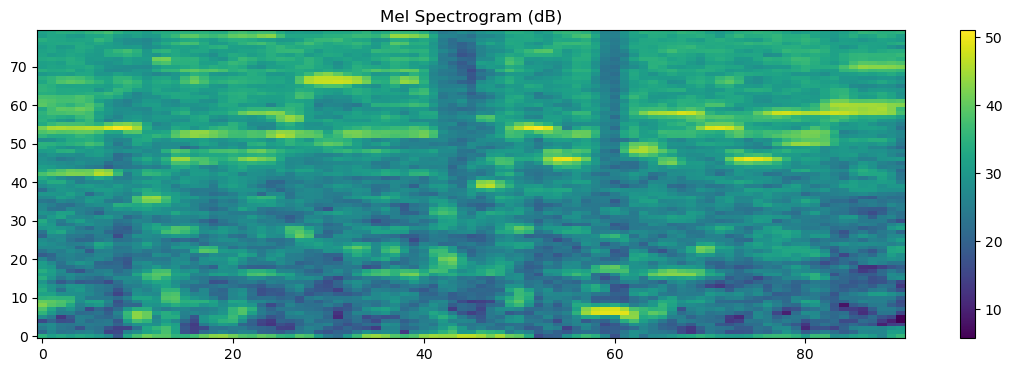

In [53]:
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

fn = "./samples/ep0004_привет.wav"  # или ep0004_здравствуйте.wav
wav, sr = torchaudio.load(fn)
wav = wav.mean(0).numpy()  # Если вдруг стерео, делаем моно

plt.figure(figsize=(14, 3))
plt.plot(wav)
plt.title('Waveform')
plt.show()

mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr, n_fft=1024, hop_length=256, n_mels=80)(torch.from_numpy(wav))
mel_db = torchaudio.transforms.AmplitudeToDB()(mel)
plt.figure(figsize=(14, 4))
plt.imshow(mel_db.numpy(), aspect='auto', origin='lower')
plt.title('Mel Spectrogram (dB)')
plt.colorbar()
plt.show()


In [19]:
for mel, _ in train_dataloader:
    print("mean", mel.mean().item(), "std", mel.std().item(), "min", mel.min().item(), "max", mel.max().item())
    break


mean 0.06029033660888672 std 0.9388961791992188 min -1.5221805572509766 max 3.006444215774536


In [81]:
print("betas", trainer.noise_sched.betas[:10])
print("alpha_hat", trainer.noise_sched.alpha_hat[:10])


betas tensor([0.0002, 0.0002, 0.0003, 0.0003, 0.0004, 0.0004, 0.0005, 0.0005, 0.0006,
        0.0006])
alpha_hat tensor([0.9998, 0.9996, 0.9994, 0.9991, 0.9987, 0.9983, 0.9978, 0.9972, 0.9967,
        0.9960], device='cuda:0')


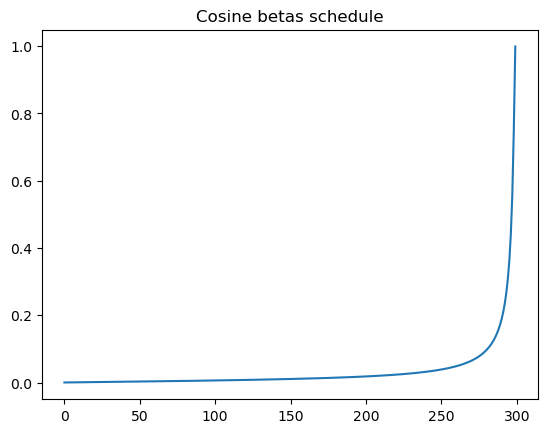

In [82]:
import matplotlib.pyplot as plt
plt.plot(trainer.noise_sched.betas.cpu().numpy())
plt.title("Cosine betas schedule")
plt.show()


In [24]:
import torch
import torch.nn as nn

class CopyNet(nn.Module):
    def __init__(self, channels=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.Conv2d(channels, channels, 1),
        )
        # Identity init
        with torch.no_grad():
            self.net[0].weight.zero_()
            self.net[1].weight.zero_()
            for i in range(channels):
                self.net[0].weight[i, i, 0, 0] = 1.0
                self.net[1].weight[i, i, 0, 0] = 1.0
            self.net[0].bias.zero_()
            self.net[1].bias.zero_()
    def forward(self, x, *args):
        return self.net(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
B, C, H, W = 16, 32, 20, 30
model = CopyNet(C).to(DEVICE)
x = torch.randn(B, C, H, W, device=DEVICE)
y = model(x)
print('diff:', (y-x).abs().mean().item())
print('LOSS:', ((y-x)**2).mean().item())


diff: 0.00014024911797605455
LOSS: 4.2928292032229365e-08


In [30]:
import torch
import torch.nn as nn

class ResBlockIdentity(nn.Module):
    def __init__(self, channels=32):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        with torch.no_grad():
            # conv1 = identity, conv2 = zero
            self.conv1.weight.zero_()
            for i in range(channels):
                self.conv1.weight[i, i, 1, 1] = 1.0
            self.conv1.bias.zero_()
            self.conv2.weight.zero_()
            self.conv2.bias.zero_()
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
B, C, H, W = 16, 32, 20, 30
model = ResBlockIdentity(C).to(DEVICE)
x = torch.randn(B, C, H, W, device=DEVICE)
y = model(x)
print("ResBlockIdentity copy test")
print('pred mean/std:', y.mean().item(), y.std().item())
print('x mean/std:   ', x.mean().item(), x.std().item())
print('diff:         ', (y-x).abs().mean().item())
print('LOSS:', ((y-x)**2).mean().item())


ResBlockIdentity copy test
pred mean/std: 0.001098082517273724 1.0010617971420288
x mean/std:    0.001098082517273724 1.0010617971420288
diff:          0.0
LOSS: 0.0


In [18]:
for mel, texts in train_dataloader:
    B = mel.size(0)
    x = torch.randn(B, 32, 20, 30, device=device)
    ids = torch.zeros(B, 1, dtype=torch.long, device=device)
    t = torch.randint(0, 500, (B,), device=device)
    pred = tts_model(x, ids, t)
    print("pred mean/std:", pred.mean().item(), pred.std().item())
    print("x mean/std:   ", x.mean().item(), x.std().item())
    print("diff:         ", (pred-x).abs().mean().item())
    loss = ((pred - x)**2).mean()
    print("LOSS:", loss.item())
    break


NameError: name 'tts_model' is not defined

In [15]:
with torch.no_grad():
    mel, _ = next(iter(train_dataloader))
    mel = mel.to(device).float()  # КИДАЕМ НА DEVICE!
    print("MEL mean/std:", mel.mean().item(), mel.std().item())

    mu, _ = vae.encode(mel)
    print("MU mean/std:", mu.mean().item(), mu.std().item())


MEL mean/std: 0.0023051134776324034 1.0192241668701172
MU mean/std: 0.02492048777639866 0.6073916554450989


In [126]:
mel_mean = -5.48   # ← подставь своё, или вычисли по всему train
mel_std  = 5.20

# в DataLoader или прямо перед входом в VAE/UNet
mel = (mel - mel_mean) / mel_std
mel

tensor([[[[0.7456, 0.7456, 0.7600,  ..., 1.1952, 1.1427, 1.1305],
          [0.7456, 0.7456, 0.7595,  ..., 1.2309, 1.2008, 1.1639],
          [0.7456, 0.7456, 0.7594,  ..., 1.2491, 1.2065, 1.1912],
          ...,
          [0.7456, 0.7456, 0.7469,  ..., 1.2974, 1.2910, 1.2967],
          [0.7456, 0.7456, 0.7467,  ..., 1.2798, 1.2470, 1.2299],
          [0.7456, 0.7456, 0.7473,  ..., 1.1862, 1.1870, 1.1758]]],


        [[[0.7456, 0.9047, 0.9944,  ..., 1.1595, 1.1588, 1.1511],
          [0.7456, 0.9118, 1.0298,  ..., 1.1788, 1.1889, 1.1953],
          [0.7456, 0.9186, 1.0906,  ..., 1.1740, 1.1988, 1.2064],
          ...,
          [0.7456, 0.7673, 0.8910,  ..., 0.9574, 0.9698, 1.0673],
          [0.7456, 0.7551, 0.8524,  ..., 0.9525, 0.9851, 1.0591],
          [0.7456, 0.7485, 0.8238,  ..., 0.9246, 0.9536, 1.0322]]],


        [[[0.7456, 0.7618, 0.9014,  ..., 1.2314, 1.2609, 1.2503],
          [0.7456, 0.7589, 0.9010,  ..., 1.2217, 1.2222, 1.1999],
          [0.7456, 0.7584, 0.8998,  ..

In [16]:
with torch.no_grad():
    mel, _ = next(iter(train_dataloader))
    mel = mel.to(DEVICE).float()
    print("[RAW MEL]   mean/std:", mel.mean().item(), mel.std().item())

    mu, _ = vae.encode(mel)
    print("[VAE MU]    mean/std:", mu.mean().item(), mu.std().item())

    x = tts_model.input_scaler(mu)
    print("[IN SCALER] mean/std:", x.mean().item(), x.std().item())

    # ids, t фиктивные
    ids = torch.zeros(x.shape[0], 1, dtype=torch.long, device=DEVICE)
    t = torch.randint(0, 500, (x.shape[0],), device=DEVICE)
    pred = tts_model(x, ids, t)
    print("[PRED]      mean/std:", pred.mean().item(), pred.std().item())


NameError: name 'DEVICE' is not defined

In [124]:
import torch
import torch.nn as nn

# Минимальная заглушка для word_enc и noise_enc
class DummyEnc(nn.Module):
    def forward(self, x):
        return torch.zeros(x.shape[0], 8, device=x.device)  # Просто пример

class DummyTTSDiffusion(nn.Module):
    def __init__(self, input_channels=32, hidden_dims=128):
        super().__init__()
        self.input_scaler = nn.Conv2d(input_channels, hidden_dims, 1)
        self.word_enc = DummyEnc()
        self.noise_enc = DummyEnc()
        # Можно добавить другие слои если нужно

    def forward(self, x, text, noise):
        x = self.input_scaler(x)
        return x

# --- Конфиг ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
B, C, H, W = 16, 32, 20, 30  # input_channels = 32!
x = torch.randn(B, C, H, W, device=DEVICE)
ids = torch.zeros(B, 1, dtype=torch.long, device=DEVICE)
t = torch.randint(0, 500, (B,), device=DEVICE)

tts_model = DummyTTSDiffusion(input_channels=C, hidden_dims=128).to(DEVICE)
pred = tts_model(x, ids, t)
print("pred shape:", pred.shape)


pred shape: torch.Size([16, 128, 20, 30])


In [107]:
import torch
import torch.nn as nn

# === 1. Сеть с одной 1x1 conv, identity инициализация ===
class IdentityNet(nn.Module):
    def __init__(self, channels=32):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 1)
        # Identity weights
        with torch.no_grad():
            self.conv.weight.zero_()
            for i in range(channels):
                self.conv.weight[i, i, 0, 0] = 1.0
            if self.conv.bias is not None:
                self.conv.bias.zero_()
    def forward(self, x, ids=None, t=None):
        return self.conv(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
B, C, H, W = 16, 32, 20, 30

# === 2. Проверка ===
net = IdentityNet(C).to(DEVICE)
x = torch.randn(B, C, H, W, device=DEVICE)
y = net(x)

print('pred mean/std:', y.mean().item(), y.std().item())
print('x mean/std:   ', x.mean().item(), x.std().item())
print('diff:         ', (y-x).abs().mean().item())
loss = ((y - x)**2).mean()
print('LOSS:', loss.item())

# === 3. Доп: Обучение для случайных весов (если надо) ===
# (после identity теста попробуй раскомментировать)

net = nn.Conv2d(C, C, 1).to(DEVICE)
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
for i in range(50):
    x = torch.randn(B, C, H, W, device=DEVICE)
    y = net(x)
    loss = ((y-x)**2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(f'Step {i} LOSS:', loss.item(), 'y std:', y.std().item())



pred mean/std: 0.0012824267614632845 0.9999904632568359
x mean/std:    0.0012822626158595085 0.9999904632568359
diff:          0.00014021788956597447
LOSS: 4.287574029149255e-08
Step 0 LOSS: 1.3832753896713257 y std: 0.5871544480323792
Step 1 LOSS: 1.3055018186569214 y std: 0.5392410755157471
Step 2 LOSS: 1.2406057119369507 y std: 0.49443697929382324
Step 3 LOSS: 1.1754134893417358 y std: 0.4497585594654083
Step 4 LOSS: 1.1199331283569336 y std: 0.4083406925201416
Step 5 LOSS: 1.0734137296676636 y std: 0.3705170750617981
Step 6 LOSS: 1.0269029140472412 y std: 0.3349369466304779
Step 7 LOSS: 0.9892199039459229 y std: 0.30332714319229126
Step 8 LOSS: 0.9505068063735962 y std: 0.27339836955070496
Step 9 LOSS: 0.9177201390266418 y std: 0.2472599446773529
Step 10 LOSS: 0.8881686329841614 y std: 0.22597575187683105
Step 11 LOSS: 0.8608545064926147 y std: 0.20957480370998383
Step 12 LOSS: 0.8368463516235352 y std: 0.19706271588802338
Step 13 LOSS: 0.8139805793762207 y std: 0.18996694684028625

In [118]:
class TestNet4(nn.Module):
    def __init__(self, channels=32):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.GroupNorm(1, channels),
            nn.SiLU(),
            nn.Conv2d(channels, channels, 1),
        )
        # Identity init (Conv2d и GroupNorm)
        with torch.no_grad():
            self.seq[0].weight.zero_()
            self.seq[3].weight.zero_()
            for i in range(channels):
                self.seq[0].weight[i, i, 0, 0] = 1.0
                self.seq[3].weight[i, i, 0, 0] = 1.0
            if self.seq[0].bias is not None:
                self.seq[0].bias.zero_()
            if self.seq[3].bias is not None:
                self.seq[3].bias.zero_()
            # GroupNorm — веса и биасы:
            self.seq[1].weight.data.fill_(1.0)
            self.seq[1].bias.data.zero_()
    def forward(self, x, ids=None, t=None):
        return self.seq(x)

net = TestNet4(C).to(DEVICE)
y = net(x)
print('TEST 4 — Conv2d + GroupNorm + SiLU + Conv2d')
print('pred mean/std:', y.mean().item(), y.std().item())
print('x mean/std:   ', x.mean().item(), x.std().item())
print('diff:         ', (y-x).abs().mean().item())
print('LOSS:', ((y-x)**2).mean().item())


TEST 4 — Conv2d + GroupNorm + SiLU + Conv2d
pred mean/std: 0.2065587341785431 0.5599709749221802
x mean/std:    0.0003471145173534751 0.9993669986724854
diff:          0.39821335673332214
LOSS: 0.3547676205635071


In [73]:
with torch.no_grad():
    mel,_ = next(iter(train_dataloader))
    mel = mel[:1].to(DEVICE).float()
    mu, _ = vae.encode(mel)
    rec = vae.decode(mu)
    print("orig", mel[0,0,:5,:5])
    print("rec ", rec[0,0,:5,:5])


orig tensor([[-13.8155, -13.8132, -13.3143,  -9.8380,  -9.4138],
        [-13.8155, -13.8128, -12.9966,  -9.6403,  -9.5179],
        [-13.8155, -13.8124, -12.7884,  -9.4129,  -9.3284],
        [-13.8155, -13.8120, -13.2895,  -9.1416,  -9.0477],
        [-13.8155, -13.8114, -12.8639,  -8.3125,  -7.5204]], device='cuda:0')
rec  tensor([[-16.5067, -16.0168, -15.0462, -12.0946, -11.3882],
        [-14.5068, -13.2474, -16.1748, -11.2546, -10.5191],
        [-14.6495, -14.9633, -13.8095, -10.9137, -10.4092],
        [-13.7809, -13.8540, -14.4292, -10.5192,  -9.8835],
        [-14.8898, -13.6296, -13.0615,  -9.5926,  -8.7223]], device='cuda:0')


In [74]:
x_t = torch.randn(1, 32, 20, 30).to(DEVICE)
ids = tts_model.word_enc.tokenize(["привет"]).to(DEVICE)
t = torch.tensor([0]).to(DEVICE)
with torch.no_grad():
    pred = tts_model(x_t, ids, t)
print(pred.shape, x_t.shape)


torch.Size([1, 32, 20, 30]) torch.Size([1, 32, 20, 30])


In [84]:
with torch.no_grad():
    mel0, _ = next(iter(val_dataloader))
    mel0 = mel0[:1].to(DEVICE).float()
    mu, _ = vae.encode(mel0)
    t = torch.randint(0, trainer.noise_sched.steps, (1,), device=DEVICE)
    eps = torch.randn_like(mu)
    x_t = trainer._q_sample(mu, t, eps)
    ids = tts_model.word_enc.tokenize(["привет"]).to(DEVICE)
    pred = tts_model(x_t, ids, t)
    print(pred.mean(), pred.std(), eps.mean(), eps.std())


tensor(-0.0026, device='cuda:0') tensor(0.0325, device='cuda:0') tensor(-0.0029, device='cuda:0') tensor(0.9995, device='cuda:0')


In [7]:
pip install git+https://github.com/bshall/hifigan.git


  Running command git clone --filter=blob:none --quiet https://github.com/bshall/hifigan.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-fxzpn7i2'
ERROR: git+https://github.com/bshall/hifigan.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.



  Cloning https://github.com/bshall/hifigan.git to c:\users\user\appdata\local\temp\pip-req-build-fxzpn7i2
  Resolved https://github.com/bshall/hifigan.git to commit 49c16c935cea45ba4073811de974d9ae277c3bc9


In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

vocoder = torch.hub.load("bshall/hifigan", "hifigan_hubert_soft", trust_repo=True)
vocoder = vocoder.to(DEVICE).eval()

Using cache found in C:\Users\User/.cache\torch\hub\bshall_hifigan_main


In [62]:
# 1) Возьмём первый батч из даталоадера
mel_gt, _ = next(iter(train_dataloader))  # (B,1,80,T)
mel_gt = mel_gt[0:1].to(DEVICE)            # (1,1,80,T)

# 2) Преобразуем его в wav
wav_gt = mel_to_audio(mel_gt.cpu())        # CPU-тензор (T,)

# 3) Сохраним в файл и тут же проиграем (если IDE позволяет)
torchaudio.save("gt_check.wav", wav_gt.unsqueeze(0), SR)
print("GT audio saved → gt_check.wav; длина сигнала:", wav_gt.abs().max().item())


GT audio saved → gt_check.wav; длина сигнала: 1.0


In [68]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Подготовка одного примера
mel, _   = next(iter(train_dataloader))
mel      = mel[:1].to(DEVICE)                  # (1,1,80,T)
with torch.no_grad():
    z0       = vae.encode(mel)[0]              # μ: (1,C,H,W)
z0 = z0.detach()                                # ОТДЕЛЯЕМ от графа VAE

text_ids = torch.zeros(1,1, dtype=torch.long, device=DEVICE)
steps     = trainer.noise_sched.steps
alpha_hat = trainer.noise_sched.alpha_hat.to(DEVICE)

def q_sample(z, t, eps):
    a = alpha_hat[t].view(-1,1,1,1)
    return a.sqrt()*z + (1-a).sqrt()*eps

# 2) Overfit ε-prediction
model = tts_model
opt   = AdamW(model.parameters(), lr=1e-3)

for i in range(1000):
    # случайный шаг t
    t   = torch.randint(0, steps, (1,), device=DEVICE, dtype=torch.long)
    eps = torch.randn_like(z0)
    x_t = q_sample(z0, t, eps)

    pred = model(x_t, text_ids, t)
    if pred.shape != eps.shape:
        pred = F.interpolate(pred, eps.shape[-2:], mode="bilinear")

    loss = F.mse_loss(pred, eps)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"iter {i:04d} loss={loss.item():.4f}  pred_mean={pred.abs().mean().item():.4f}")


iter 0000 loss=0.9909  pred_mean=0.0193
iter 0100 loss=1.0155  pred_mean=0.0324


KeyboardInterrupt: 

In [ ]:
# берём любой реальный mel из даталодера
m, _ = next(iter(train_dataloader))        # (B,1,80,T)
wav = mel_to_audio(m[:1].cpu())            # Tensor (T,)

print("amp max =", wav.abs().max().item()) # должно быть ≈ 1.0
display(Audio(wav.numpy(), rate=SR))       # должен заиграть реальный звук


L1(log-mel) = 0.6047


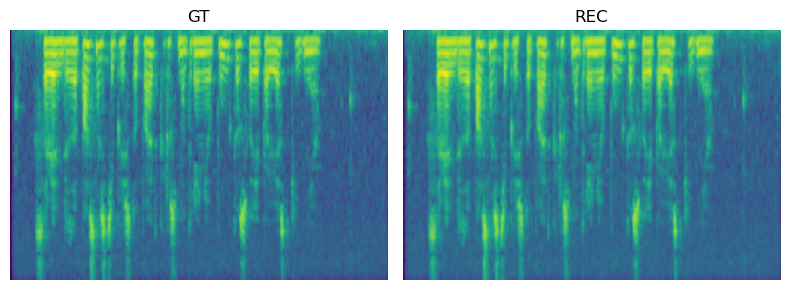

✓ Saved check_orig.wav & check_recon.wav


In [71]:
import torch
import torchaudio
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Параметры мел-спектра
SR, N_FFT, HOP, WIN, N_MELS = 16_000, 800, 200, 800, 80
device = "cuda" if torch.cuda.is_available() else "cpu"

melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
    win_length=WIN, n_mels=N_MELS, power=2.0
).to(device)

inv_mel = torchaudio.transforms.InverseMelScale(
    n_stft=N_FFT//2+1, n_mels=N_MELS, sample_rate=SR
).to(device)
griffin = torchaudio.transforms.GriffinLim(
    n_fft=N_FFT, hop_length=HOP, win_length=WIN,
    power=1.0, n_iter=64, momentum=0.99
).to(device)

def wav2logmel(wav):
    return (melspec(wav) + 1e-6).log()

def mel2wav(mel_log):
    m = mel_log.squeeze(0).squeeze(0).exp()  # (80, T)
    S = inv_mel(m)                          # (freq, T)
    M = S.clamp_min(1e-9).sqrt()            # (freq, T)
    w = griffin(M)                          # (T,)
    return (w / w.abs().max()).cpu()

# 2) Загружаем VAE
vae = VAE_Audio().to(device)
vae.load_state_dict(torch.load("TTSVAE_v4.5.pt", map_location=device))
vae.eval()

# 3) Грунтовый мел
wav, _ = torchaudio.load("E:/data/bare_data/common_voice_ru_18849005.wav")
wav = wav.to(device)
mel_gt = wav2logmel(wav).unsqueeze(0)         # shape (1,1,80,Tgt)

# 4) Реконструкция через μ
with torch.no_grad():
    mu, logvar = vae.encode(mel_gt)
    mel_rec = vae.decode(mu)                  # shape (1,1,80,Trec)

# 5) Выравнивание по времени
Tgt = mel_gt.size(-1)
Trec = mel_rec.size(-1)
if Trec > Tgt:
    mel_rec = mel_rec[..., :Tgt]
elif Trec < Tgt:
    mel_rec = F.pad(mel_rec, (0, Tgt - Trec))

# 6) L1-метрика
l1 = F.l1_loss(mel_rec, mel_gt).item()
print(f"L1(log-mel) = {l1:.4f}")

# 7) Визуализация
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title("GT")
plt.imshow(mel_gt[0,0].cpu().detach(), aspect="auto"); plt.axis("off")
plt.subplot(1,2,2)
plt.title("REC")
plt.imshow(mel_rec[0,0].cpu().detach(), aspect="auto"); plt.axis("off")
plt.tight_layout(); plt.show()

# 8) Сохранение WAV
wav_gt  = mel2wav(mel_gt)
wav_rec = mel2wav(mel_rec)
torchaudio.save("check_orig.wav",  wav_gt.unsqueeze(0), SR)
torchaudio.save("check_recon.wav", wav_rec.unsqueeze(0), SR)
print("✓ Saved check_orig.wav & check_recon.wav")


In [ ]:
wav = text_to_speech("Привет", trainer.model, trainer.vae,
                     trainer.noise_sched, temp=0.7)

print("amp max =", wav.abs().max().item())
display(Audio(wav.numpy(), rate=SR))


In [107]:
import torch
import torch.nn.functional as F
import torchaudio

# ---------------------- 1. Параметры ----------------------
SR, N_FFT, HOP, WIN, N_MELS = 16000, 800, 200, 800, 80
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------- 2. Загрузка VAE ----------------------
# Ваш класс VAE_Audio уже должен быть в скоупе
vae = VAE_Audio().to(device)
vae.load_state_dict(torch.load("TTSVAE_v4.5.pt", map_location=device))
vae.eval()

# ---------------------- 3. Получаем один батч латентов z0 ----------------------
# loader выдаёт (mel, text), мел — уже pad/trim до единой длины
with torch.no_grad():
    mel_batch, _ = next(iter(loader))   # shape: (B,1,80,T)
    mel_batch    = mel_batch.to(device)
    mu, _        = vae.encode(mel_batch)  # (B, C, H', W')
z0 = mu  # детермин. латент (B, C, H', W')

# ---------------------- 4. Создаём TTS_diffusion ----------------------
# Передаём реальные параметры из вашего тренера
model = TTS_diffusion(
    input_channels = z0.size(1),            # совпадает с C
    hidden_dims    = 128,
    alphabet       = "абвгдеёжзийклмнопрстуфхцчшщъыьэюя",
    emb_size_word  = 64,
    emb_size_noise = 32,
    noise_steps    = trainer.noise_sched.steps,
    max_word_size  = 1,                     # текст здесь фиктивный
    max_time_size  = z0.shape[-1]           # ширина латента
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-3)

# ---------------------- 5. Scheduler (α̂) ----------------------
alpha_hat = trainer.noise_sched.alpha_hat.to(device)  # (steps,)
steps     = alpha_hat.size(0)

def q_sample(z, t, eps):
    a = alpha_hat[t].view(-1,1,1,1)
    return a.sqrt() * z + (1 - a).sqrt() * eps

# ---------------------- 6. Dummy text_ids ----------------------
text_ids = torch.zeros(z0.size(0), 1, dtype=torch.long, device=device)

# ---------------------- 7. Overfit loop ε-only ----------------------
for i in range(2000):
    t   = torch.randint(0, steps, (z0.size(0),), device=device)
    eps = torch.randn_like(z0)
    x_t = q_sample(z0, t, eps)

    pred = model(x_t, text_ids, t)       # (B, C, H', W')
    if pred.shape != eps.shape:
        pred = F.interpolate(pred, size=eps.shape[-2:], mode="bilinear")

    loss = F.mse_loss(pred, eps)

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    if i % 100 == 0:
        # вычисляем grad norm
        gn = sum(p.grad.data.norm(2).item()**2 for p in model.parameters() if p.grad is not None)**0.5
        print(f"iter {i:04d}  loss={loss.item():.4f}  grad_norm={gn:.4e}")


iter 0000  loss=1.1569  grad_norm=1.0000e+00
iter 0100  loss=1.0015  grad_norm=3.9806e-02
iter 0200  loss=1.0053  grad_norm=3.9303e-02
iter 0300  loss=1.0020  grad_norm=3.3569e-02
iter 0400  loss=1.0047  grad_norm=3.1219e-02
iter 0500  loss=0.9999  grad_norm=3.0493e-02


KeyboardInterrupt: 

In [108]:
print(alpha_hat[:10].cpu().numpy())
print(alpha_hat[-10:].cpu().numpy())


[0.999745   0.9993687  0.9988712  0.9982525  0.9975128  0.99665236
 0.99567133 0.99456996 0.9933486  0.9920073 ]
[4.9101985e-03 3.8809993e-03 2.9722932e-03 2.1842904e-03 1.5172055e-03
 9.7118795e-04 5.4637011e-04 2.4285527e-04 6.0717161e-05 6.0716381e-08]


In [47]:
import os, pandas as pd
bad = df = pd.read_csv("E:/data/train.csv")["path"].apply(lambda p: not os.path.exists(f"E:/data/bare_data/{p}"))
print("битых файлов:", bad.sum())


C:\Users\User\AppData\Local\Temp\ipykernel_26572\2471478738.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  bad = df = pd.read_csv("E:/data/train.csv")["path"].apply(lambda p: not os.path.exists(f"E:/data/bare_data/{p}"))


битых файлов: 0


In [ ]:
from IPython.display import Audio, display
# 1) latent-L1 (после Patch A) должен начать снижаться
print(trainer.latent_l1_val(max_batches=5))   # ↘ 0.35 → 0.25 → 0.15 …

# 2) прослушать любой новый сэмпл (после Patch B)
display(Audio('./samples/ep01_привет.wav'))


In [ ]:
wav0 , sr = torchaudio.load("E:/data/bare_data/common_voice_ru_18849003.wav")
assert sr == SR, "файл не 16 kHz — resample перед тестом"

mel  = wav_to_mel(wav0)                # (1,80,Tm)
wav1 = mel_to_audio(mel.unsqueeze(0))  # (Tw,)

# ――― согласуем длины ―――
L = min(wav0.shape[-1], wav1.shape[-1])
wav0, wav1 = wav0[..., :L], wav1[..., :L]

snr = 10 * torch.log10(((wav0**2).mean() / ((wav0 - wav1)**2).mean()))
print("SNR дБ:", snr.item(), " |  amp(wav1) max =", wav1.abs().max().item())

from IPython.display import Audio, display
display(Audio(wav1.squeeze().numpy(), rate=SR))


In [66]:
from IPython.display import Audio, display
import torch.nn.functional as F

mel, _ = next(iter(train_dataloader))          # (B,1,80,T)
mel     = mel[:1].to(device).float()           # на GPU

with torch.no_grad():
    recon, _, _ = vae.sample(mel)              # recon тоже на GPU

# 1) Слушаем:
wav = mel_to_audio(recon.cpu())                # CPU для Audio
print("amp max =", wav.abs().max().item())
display(Audio(wav.numpy(), rate=16000))

# 2) Метрика MSE на GPU:
mse = F.mse_loss(recon, mel).item()            # оба на GPU
print("VAE mel-MSE:", mse)


amp max = 1.0


VAE mel-MSE: 2.9691379070281982


In [93]:
from IPython.display import Audio, display
import torch.nn.functional as F

mel, _ = next(iter(train_dataloader))      # (B,1,80,T)
mel     = mel[:1].to(device).float()

with torch.no_grad():
    # sample() тут отдает (recon, mu, logvar)
    recon, mu, logvar = vae.sample(mel)

# 1) Послушать
wav_rec = mel_to_audio(recon.cpu())
print("amp max =", wav_rec.abs().max().item())
display(Audio(wav_rec.numpy(), rate=16000))

# 2) Посчитать MSE по мелу
mse = F.mse_loss(recon, mel).item()
print("VAE mel-MSE:", mse)


amp max = 1.0


VAE mel-MSE: 3.586452007293701


In [95]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from itertools import islice

# ---- Подготовка батча ----
model = tts_model  # ваша модель
model.train()
batch = next(iter(train_dataloader))   # (mels, texts)
mels, texts = batch
mels = mels.to(device).float()
texts_ids = model.word_enc.tokenize(texts).to(device)

# Получаем настоящий латент z из уже обученного VAE:
with torch.no_grad():
    _, mu, logvar = vae.sample(mels)
    std = (0.5 * logvar).exp()
    z0 = mu + torch.randn_like(std) * std  # [B,32,h,w]

# Сразу зафиксируем шумовые шаги:
steps = trainer.noise_sched.steps
noise_idx = torch.randint(0, steps, (z0.size(0),), device=device)
x_t, eps = trainer.noise_sched.corrupt_image(z0, noise_idx)

# Оптимизатор и планировщик
opt = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
sched = OneCycleLR(opt, max_lr=3e-4, total_steps=300)

print("🚀 Проверка цикла обучения (300 шагов, OneCycleLR):")
for step in range(300):
    opt.zero_grad()

    # forward
    eps_hat = model(x_t, texts_ids, noise_idx)      # model должен вернуть тензор той же формы что x_t
    # если eps_hat != eps по spatial-форме, ресайзим целевой шум:
    if eps_hat.shape != eps.shape:
        eps_resized = F.interpolate(eps, size=eps_hat.shape[-2:], 
                                    mode='bilinear', align_corners=False)
    else:
        eps_resized = eps

    # чистый MSE
    loss = F.mse_loss(eps_hat, eps_resized)
    loss.backward()

    # градиент-клиппинг
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    opt.step()
    sched.step()

    if step % 50 == 0:
        print(f"iter {step:03d}  loss={loss.item():.4f}  lr={sched.get_last_lr()[0]:.1e}")


🚀 Проверка цикла обучения (300 шагов, OneCycleLR):
iter 000  loss=1.1523  lr=1.2e-05


KeyboardInterrupt: 

In [32]:
with torch.no_grad():
    wav = mel_to_audio(mel_db)  # попробовать +10…+20 dB
torchaudio.save("test.wav", wav.unsqueeze(0), 16_000)

print("wav min/max:", wav.min().item(), wav.max().item())
# должно быть примерно −0.9 … +0.9


NameError: name 'mel_db' is not defined

In [113]:
# ─── sanity-check для уже загруженного `vae` ────────────────────────────────
import torch, torch.nn.functional as F, numpy as np

# возьмём первые 10 батчей из того, что уже есть (train_dataloader → mel-80×80)
mse, mu_m, mu_s, lv_m = [], [], [], []
for i, (mel, _) in enumerate(train_dataloader):
    if i == 100: break                     # достаточно
    mel = mel.to(device).float()          # (B,1,80,80)
    rec, mu, logvar = vae.sample(mel)
    mse  .append(F.mse_loss(rec, mel).item())
    mu_m .append(mu.mean().item())        # среднее μ
    mu_s .append(mu.std ().item())        # σ(μ)   ~ 1?
    lv_m .append(logvar.mean().item())    # ⟨log σ²⟩

print(f"\n▸ VAE quick report  (avg over {len(mse)} batches)")
print(f"   recon MSE      : {np.mean(mse):.4f}")
print(f"   mu  mean / std : {np.mean(mu_m):+.4f} / {np.mean(mu_s):.4f}")
print(f"   ⟨log σ²⟩        : {np.mean(lv_m):+.4f}")

# ─── заодно глянем, что выдаёт ваш NoiseScheduler ───────────────────────────
sched = NoiseScheduler(300, 1)       # те же 300 шагов
sched.alpha     = sched.alpha.to(device)
sched.alpha_hat = sched.alpha_hat.to(device)

idx   = torch.randint(0, sched.steps, (128,), device=device)
dummy = torch.randn(128, 32, 7, 7, device=device)
_, eps = sched.corrupt_image(dummy, idx)

scale = torch.sqrt(1. - sched.alpha_hat[idx]).view(-1,1,1,1)
print(f"\n▸ NoiseScheduler check")
print(f"   (eps/scale) σ  : {eps.div(scale).std().item():.4f}  (должно быть ≈1)")
print(f"   scale min/max  : {scale.min().item():.3f} … {scale.max().item():.3f}")


▸ VAE quick report  (avg over 32 batches)
   recon MSE      : 16.7879
   mu  mean / std : +0.0155 / 1.0685
   ⟨log σ²⟩        : -0.4544

▸ NoiseScheduler check
   (eps/scale) σ  : 1.4102  (должно быть ≈1)
   scale min/max  : 0.141 … 0.975


In [110]:
# @torch.inference_mode()
# def text_to_speech(
#         text:str,S
#         tts:TTS_diffusion,
#         vae:VAE_Audio,
#         sched:NoiseScheduler,
#         temp:float = 0.7,
#         device:torch.device|str = None
#     )->torch.Tensor:

#     device = device or next(tts.parameters()).device
#     ids = tts.word_enc.tokenize([text]).to(device)

#     dummy  = torch.zeros(1, 1, 80, 80, device=device)
#     zshape = tts.resize_to_square(vae.sample(dummy)[0], tts.patch_img1_size).shape
#     z = torch.randn(zshape, device=device) * temp

#     for t in reversed(range(sched.steps)):
#         eps = tts(z, ids, torch.tensor([t], device=device))
#         if eps.shape[-2:] != z.shape[-2:]:
#             eps = torch.nn.functional.interpolate(eps, z.shape[-2:], mode="bilinear", align_corners=False)

#         sigma = 0.0 if t < sched.steps*0.2 else 1e-4
#         z = sched.restore_image(z, eps, t, sigma=sigma)

#     mel = vae.decode(z).cpu()
#     return mel_to_audio(mel)

# all_epochs = 30

# trainer = TTS_Trainer(
#     model=tts_model,
#     train_dataloader=train_dataloader,
#     val_dataloader=val_dataloader,
#     vae=vae,
#     epochs=all_epochs
# )

# for epoch in range(all_epochs):
#     print(f"\n Epoch: {epoch + 1}/{all_epochs}")
#     trainer.train_loop()
#     trainer.val_loop(iteration=epoch)
#     tts_model.eval()
#     l1_score = trainer.latent_l1_val(max_batches=20)
#     print(f"[epoch {epoch+1:02d}] validation latent-L1 = {l1_score:.4f}")
#     for text in ["Привет, как дела?",
#                  "Сегодня солнечная погода."]:
#         with torch.no_grad():
#             wav = text_to_speech(text, temp=0.7)
#         fn = f"./samples/ep{epoch+1:02d}_{text[:8]}.wav"
#         torchaudio.save(fn, wav.unsqueeze(0), 16_000)
#     print(f"Сэмплы сохранены в ./samples/ (эпоха {epoch+1})")

# torch.save(tts_model.state_dict(), "TTSModelParametersNew_v6.pt")

In [127]:
# ─── 1. Импорты ────────────────────────────────────────────────────────────
import torch, torchaudio, torch.nn.functional as F
from pathlib import Path
import IPython.display as ipd

# ─── 2. Глобальные параметры ───────────────────────────────────────────────
DEVICE, SR = ("cuda" if torch.cuda.is_available() else "cpu"), 16_000

# чуть шире FFT-окно и hop — лучше качество при Griffin-Lim
N_MELS, N_FFT, HOP, WIN = 80, 1024, 256, 1024

CKPT_VAE = Path("VaeAudio_V4_noise.pt")      # веса VAE
CKPT_TTS = Path("TTSModelParametersNew_v5.pt")  # веса диффузии

# ─── 3. Mel → Wave только Griffin-Lim ──────────────────────────────────────
def mel_to_audio(mel_log: torch.Tensor) -> torch.Tensor:
    """
    (1,1,80,T) лог-Mel  → wav (T,)
    Работает на любой версии torchaudio.
    """
    mel = mel_log.exp().sub_(1e-6).squeeze(0).squeeze(0)    # [80, T]

    # Inverse Mel → линейный спектр
    n_stft = N_FFT // 2 + 1
    spec   = torchaudio.transforms.InverseMelScale(
        n_stft=n_stft, n_mels=N_MELS, sample_rate=SR)(mel)

    # на всякий случай ровняем размер по частотам
    if spec.shape[0] < n_stft:
        spec = F.pad(spec, (0, 0, 0, n_stft - spec.shape[0]))
    elif spec.shape[0] > n_stft:
        spec = spec[:n_stft]

    # Griffin-Lim
    griffin = torchaudio.transforms.GriffinLim(
        n_fft=N_FFT, hop_length=HOP, win_length=WIN,
        power=1.0, n_iter=64, momentum=0.99
    )
    wav = griffin(spec)                    # (T,)
    return wav.clamp(-1, 1)

# ─── 4. Грузим обученные модели ────────────────────────────────────────────
vae = VAE_Audio().to(DEVICE)
vae.load_state_dict(torch.load(CKPT_VAE, map_location=DEVICE, weights_only=True))
vae.eval()

tts = TTS_diffusion(
    input_channels=32, hidden_dims=128,
    alphabet="абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ",
    emb_size_word=128, emb_size_noise=64,
    noise_steps=600, max_word_size=256, max_time_size=2048
).to(DEVICE)
tts.load_state_dict(torch.load(CKPT_TTS, map_location=DEVICE, weights_only=True))
tts.eval()

sched = NoiseScheduler(600)
sched.alpha      = sched.alpha.to(DEVICE)
sched.alpha_hat  = sched.alpha_hat.to(DEVICE)


# ─── 6. Проверка ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    phrase = "привет"
    audio  = text_to_speech(phrase)

    torchaudio.save("out.wav", audio.unsqueeze(0), SR)
    ipd.display(ipd.Audio(audio.numpy(), rate=SR))
    print("✓  Готово: out.wav сохранён.")


✓  Готово: out.wav сохранён.


In [5]:
from pathlib import Path
xx = Path("dataset.tsv")
import pandas as pd
df = pd.read_csv(xx, sep="\t")

C:\Users\User\AppData\Local\Temp\ipykernel_11196\816554738.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(xx, sep="\t")


In [10]:
df['path'] = df['path'].str.replace(r'\.mp3$', '.wav', regex=True)

In [129]:
df

NameError: name 'df' is not defined

In [28]:
import pandas as pd
from pathlib import Path

SRC_TSV   = Path(r"E:\data\dataset.tsv")   # ваш исходный tsv
TRAIN_CSV = Path(r"E:\data\train.csv")     # куда сохранить train
VAL_CSV   = Path(r"E:\data\val.csv")       # куда сохранить val
SEED = 42                             # чтобы деление было воспроизводимым
VAL_FRAC = 0.10                           # 10 % на валидацию

# ─── 1. читаем TSV ───────────────────────────────────────────────
df = pd.read_csv(SRC_TSV, sep='\t')

# ─── 2. случайно перемешиваем и делим ────────────────────────────
val_df   = df.sample(frac=VAL_FRAC, random_state=SEED)
train_df = df.drop(val_df.index)

# ─── 3. сохраняем в CSV (без индексов) ───────────────────────────
train_df.to_csv(TRAIN_CSV, index=False)
val_df.to_csv(VAL_CSV,     index=False)

print(f"✓ train: {len(train_df):,}  |  val: {len(val_df):,}")


C:\Users\User\AppData\Local\Temp\ipykernel_11196\586357610.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(SRC_TSV, sep='\t')


✓ train: 153,004  |  val: 17,000


In [32]:
# быстро отсекаем всё тише -35 dBFS
import soundfile as sf, numpy as np, glob
bad = []
for f in glob.glob("bare_data/*.wav"):
    rms = np.sqrt(np.mean(sf.read(f)[0]**2))
    if 20*np.log10(rms+1e-9) < -35: bad.append(f)
print("тихих файлов:", len(bad))


тихих файлов: 0


In [5]:
pip install hifi-gan==0.1.1


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement hifi-gan==0.1.1 (from versions: 0.0.1, 0.0.2)
ERROR: No matching distribution found for hifi-gan==0.1.1


In [131]:
# --- один батч, один шаг ---
mel, txt = next(iter(train_dataloader))          # (B,1,80,80)
mel = mel.to(device)

with torch.no_grad():
    z, _, _ = vae.sample(mel)                    # (B,32,*,*)  ← НЕ ресайзим!

idx  = sched.get_idx(0, z.size(0)).to(device)
txts = tts_model.word_enc.tokenize(txt).to(device)

out = tts_model(z, txts, idx)                    # (B,32,H',W')

# приводим к одной геометрии, если нужно
if out.shape[-2:] != z.shape[-2:]:
    z = torch.nn.functional.interpolate(
            z, size=out.shape[-2:], mode='bilinear', align_corners=False)

print('latent l1 =', (out - z).abs().mean().item())


latent l1 = 1.9066026210784912
